# Modeling Sleep Spindles

A Project for Statistical Machine Learning Course (YCBS 255-28)

Created by Ella Gabitov, March 2023

In this project, I use a data of a single participant collected by me and my coleagues as part of the neuroimaging study on the role of sleep in memory consolidation. The study protocol was approved by the Research Ethics Board of the RNQ (Regroupement Neuroimagerie Québec). All procedures were in accordance with the approved guidelines and regulations. Before participation, participants provided written informed consent and received financial compensation for their participation in the study.

The dataset and the code can be downloaded from [here](https://github.com/EllaGab/YCBS255-28_project.git).

The goal of this project is two-phold:
1. To build a classifier to predict the coupling of spindles with the slow waves based on their characteristics such as frequency, amplitude, sleep stage, etc.
2. To explore a possibility to predict the source of the spindle (i.e., the EEG channel) based on spindles characteristics

Classification models and tools used in the project:
- Logistic regression
- Principle component analysis
- Decision trees
- Random forest
- Cross validation
- Parameter tuning and regularization

Programming language: Python


## Background

Sleep is not only important to our well-being and health but also plays a pivotal role in cognitive function. To better undertand the mechanisms underlying the benifitial effects of sleep, scientists can measure the brain’s electrical activity using electroencephalography (EEG).


<br>
<br>
<br>

<div>
    <img src="images\BrainEEGCap.png" alt="Drawing"; style="width: 400px"/>
</div>

<br>
<br>
<br>


<br>
<br>
<br>

<div>
    <img src="images\EEG_montage.png" alt="Drawing" style="width: 400px;"/>
</div>

<br>
<br>
<br>


Sleep can be broadly divided into two types: nonrapid eye movement (NREM) sleep and rapid eye movement (REM) sleep. Based on the EEG signal, NREM can be further divided into 3 stages. Here, I refer to these stages as NREM1, NREM2, and NREM3.

<br>
<br>
<br>

<div>
    <img src="images\hypnogram Genzel et al 2014.png" alt="Drawing" style="width: 800px;"/>
</div>

Adapted from Genzel et al., *Trends in Neurosciences* (2014)

<br>
<br>
<br>


Research evidence suggests that during sleep, our brain reorganizes and strengthens memories acquired previously during the day. Two types of oscillatory activity patterns that are prevalent during the deeper stages of NREM sleep, namely sleep spindles and slow waves, seem to be particularly important to effective memory reprocessing, which in turn promotes long-term memory retention. It has been proposed that precise temporal coupling between sleep spindles and slow oscillations may be a fundamental mechanism of sleep-dependent memory consolidaiton.

<br>
<br>
<br>

<div>
    <img src="images\spindles slow waves Borislavov Iotchev and Kubinyi 2021.png" alt="Drawing" style="width: 800px;"/>
</div>

Adapted from Borislavov Iotchev & Kubinyi, *Biol Rev Camb Philos Soc* (2021)

<br>
<br>
<br>


## Load Packages

In [1]:
# Is used to change the color and the background of the printed text/message
from colorama import Fore as txt, Back as bg

class txt_style:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    RESET = '\033[0m'
    

In [2]:
import os

import scipy as sp
import statsmodels.api as sm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Load Data

In [3]:
# Data info
# Assumption: the data is within the same directory as the current notebook
dir_path = os.path.dirname(os.path.realpath('__file__'))
f_path = os.path.join(dir_path, 'CoRe_079_msl_d1_sleep1_events_sps_prep_FzCzPzC3C4_clusters_6s_all.csv')

# Read the data
df_base = pd.read_csv(f_path)

# Optimize data types
df_base = df_base.infer_objects()
print(df_base.dtypes)

display(df_base.head())

channel              object
onset               float64
duration            float64
peak_onset          float64
type                 object
frequency           float64
amplitude           float64
phase_angle         float64
lag                 float64
sw_wind_start       float64
sw_wind_end         float64
sw_neg_peak         float64
overlap               int64
cluster_size          int64
i_within_cluster      int64
NREM2               float64
NREM3               float64
NREM23                int64
dtype: object


channel    onset  duration  peak_onset    type  frequency  amplitude  \
0      Cz  330.868     0.800     331.532  sp_unc  13.197064  10.471036   
1      C4  332.460     0.740     332.596  sp_unc  14.198730   9.576715   
2      Pz  333.344     0.520     333.752  sp_unc  13.465929   8.137188   
3      C3  334.796     0.616     335.232  sp_unc  14.309011  10.655192   
4      C4  341.400     0.560     341.580  sp_unc  13.265371  19.392362   

   phase_angle  lag  sw_wind_start  sw_wind_end  sw_neg_peak  overlap  \
0          NaN  NaN            NaN          NaN          NaN        0   
1          NaN  NaN            NaN          NaN          NaN        0   
2          NaN  NaN            NaN          NaN          NaN        1   
3          NaN  NaN            NaN          NaN          NaN        0   
4          NaN  NaN            NaN          NaN          NaN        0   

   cluster_size  i_within_cluster  NREM2  NREM3  NREM23  
0             4                 1    1.0    NaN       1  
1             4                 2    2.0    NaN       2  
2             4                 3    3.0    NaN       3  
3             4                 4    4.0    NaN       4  
4             1                 1    5.0    NaN       5

**The Variables**

- channel - the EEG electrode, indicates the source of the signal
- onset - spindle onset (in seconds) from the beginning of the recordings
- duration - the duration of the spindle (in seconds)
- peak_onset - the time of the spindle peak (in seconds) from the beginning of the recordings
- type - the type of the spindle based on its coupling/co-occurance with slow waves:
    - sp_unc - uncoupled, i.e., no overlap with a slow wave
    - sp_c_up - coupled with the up-phase of the slow wave
    - sp_c_down - coupled with the down-phase of the slow wave
- frequency - spindle frequency (in Hz)
- amplitude - spindle amplitude (in $\mu$V)
- phase_angle - the angle of spindle coupling (for the uncoupled spindles is NaN)
- lag - the time interval (in seconds) between the spindle onset and the negative peak of the slow wave (for the uncoupled spindles is NaN):
    - positive values correspond to the up-phase coupling
    - negative values correspond to the down-phase coupling
- sw_wind_start/sw_wind_end - the start/end of the time-window (in seconds) used for slow wave detection (for the uncoupled spindles is NaN)
- sw_neg_peak - the onset (in seconds) of the negative peak of the slow wave coupled with the spindle (for the uncoupled spindles is NaN)
- overlap - 0: did not overlap with other spindles; 1 - overap with other spindle(s) (these spindles were removed)
- cluster_size - the number of spindles within the cluster
- i_within_cluster - the position of the spindle within the cluster
- NREM2 - the index of the spindle within the NREM2 sleep interval (for spindles occuring during NREM3 is NaN)
- NREM3 - the index of the spindle within the NREM3 sleep interval (for spindles occuring during NREM2 is NaN)
- NREM23 - the index of the spindle within the NREM2 & NREM3 sleep interval




In [4]:
# `DataFrame` with features of interest only

columns2add = ['channel', 'onset', 'duration']
df = df_base[columns2add].copy()

# Create new variables
df['peak_ratio'] = (df_base['peak_onset'] - df_base['onset']) / df['duration']
df['coupling'] = ['Uncoupled' if sp_type == 'sp_unc' else 'Coupled' for sp_type in df_base['type'].values]

columns2add = ['type', 'frequency', 'amplitude', 'phase_angle', 'lag', 'cluster_size', 'i_within_cluster']
df[columns2add] = df_base[columns2add].copy()

# Create a dummy variable for sleep stages
# - NREM2 = 0, NREM3 = 1
df['NREM'] = (np.isnan(df_base.NREM2)).astype('int')

df.head()


channel    onset  duration  peak_ratio   coupling    type  frequency  \
0      Cz  330.868     0.800    0.830000  Uncoupled  sp_unc  13.197064   
1      C4  332.460     0.740    0.183784  Uncoupled  sp_unc  14.198730   
2      Pz  333.344     0.520    0.784615  Uncoupled  sp_unc  13.465929   
3      C3  334.796     0.616    0.707792  Uncoupled  sp_unc  14.309011   
4      C4  341.400     0.560    0.321429  Uncoupled  sp_unc  13.265371   

   amplitude  phase_angle  lag  cluster_size  i_within_cluster  NREM  
0  10.471036          NaN  NaN             4                 1     0  
1   9.576715          NaN  NaN             4                 2     0  
2   8.137188          NaN  NaN             4                 3     0  
3  10.655192          NaN  NaN             4                 4     0  
4  19.392362          NaN  NaN             1                 1     0

## EDA

### Descriptive Statistics

In [5]:
# Counts

nrem_dict = {'NREM2': 0, 'NREM3': 1}
var_names = ['coupling', 'type']
title_length = 70

for var_name in var_names:
    n2pad = (title_length - len(var_name)) // 2
    print()
    print(txt_style.BOLD + '-'*n2pad + '- ' + var_name.upper() + ' -' + '-'*n2pad + txt_style.RESET)
    print()
    
    df_counts = pd.DataFrame()
    for key, value in nrem_dict.items():
        counts = df.loc[df['NREM'] == value, var_name].value_counts()
        counts.loc['total'] = counts.sum()
        df_counts[key + '_count'] = counts
        df_counts[key + '_percent'] = counts/counts[:-1].sum() * 100
        
    display(df_counts)



-------------------------------- COUPLING --------------------------------



NREM2_count  NREM2_percent  NREM3_count  NREM3_percent
Uncoupled          681      87.419769          205      74.545455
Coupled             98      12.580231           70      25.454545
total              779     100.000000          275     100.000000


---------------------------------- TYPE ----------------------------------



NREM2_count  NREM2_percent  NREM3_count  NREM3_percent
sp_unc             681      87.419769          205      74.545455
sp_c_up             68       8.729140           35      12.727273
sp_c_down           30       3.851091           35      12.727273
total              779     100.000000          275     100.000000


-------------------------------------------------- DURATION --------------------------------------------------


NREM            0           1
count  779.000000  275.000000
mean     0.721849    0.685193
std      0.226107    0.203559
min      0.492000    0.492000
25%      0.560000    0.528000
50%      0.656000    0.612000
75%      0.814000    0.764000
max      2.696000    1.444000

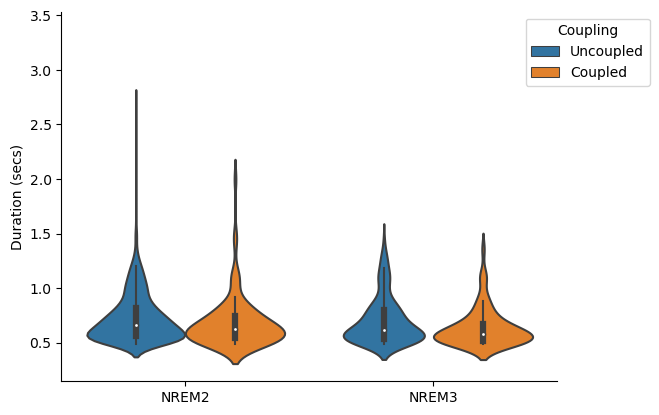


-------------------------------------------------- PEAK_RATIO --------------------------------------------------


NREM            0           1
count  779.000000  275.000000
mean     0.506767    0.494708
std      0.211518    0.213334
min      0.111475    0.111554
25%      0.298875    0.300733
50%      0.518750    0.467033
75%      0.703012    0.713025
max      0.961424    0.891447

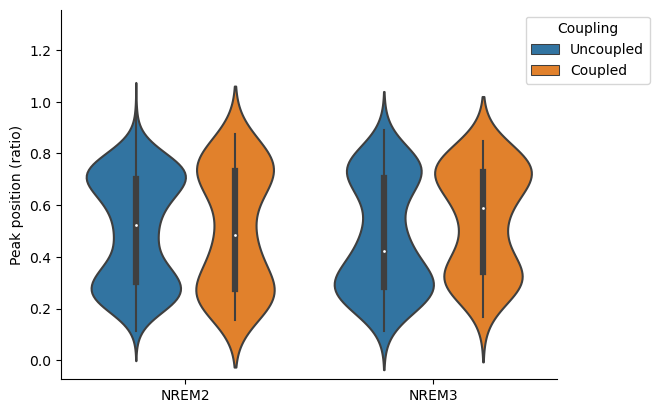


-------------------------------------------------- FREQUENCY --------------------------------------------------


NREM            0           1
count  779.000000  275.000000
mean    13.523819   13.416659
std      0.745250    0.677193
min     11.524073   11.466333
25%     12.938425   12.963464
50%     13.684008   13.467501
75%     14.125452   13.886573
max     15.099711   14.932322

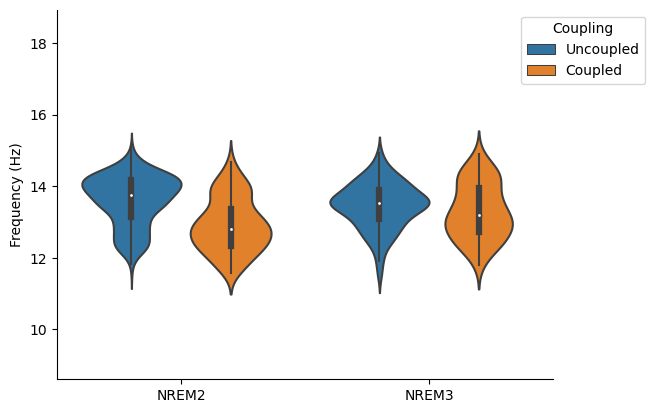


-------------------------------------------------- AMPLITUDE --------------------------------------------------


NREM            0           1
count  779.000000  275.000000
mean    16.445934   16.560588
std      4.350668    4.627869
min      8.137188    9.462433
25%     13.416603   13.170117
50%     15.527041   15.384388
75%     18.634650   19.241566
max     36.690975   37.946686

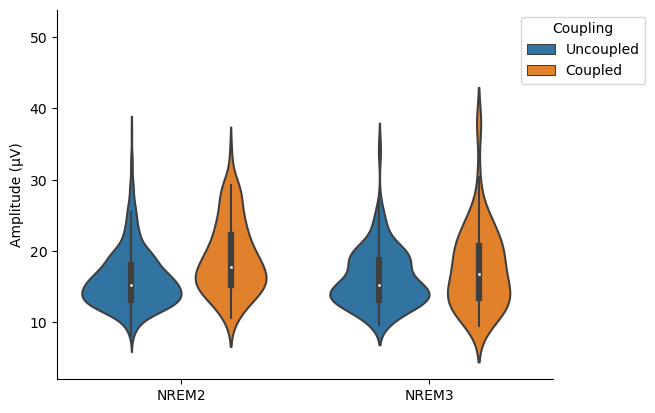

In [6]:
# Group by `NREM`

columns = ['duration', 'peak_ratio', 'frequency', 'amplitude']
y_lbls = ['Duration (secs)', 'Peak position (ratio)', 'Frequency (Hz)', 'Amplitude (μV)']

for i in range(len(columns)):
    c = columns[i]
    
    print()
    print(txt_style.BOLD + '-'*50 + ' ' + c.upper() + ' ' + '-'*50 + txt_style.RESET)
    
    # Descriptive statistics
    display(df.groupby(['NREM'])[c].describe().T)
    
    # Plot
    ax = sns.violinplot(data=df, y=c, x='NREM', hue='coupling')
  
    # Remove the top and right spine
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlabel('')
    ax.set_xticklabels(['NREM2', 'NREM3'])
    ax.set_ylabel(y_lbls[i])
    ax.set_ylim([ax.get_ylim()[0]*0.8, ax.get_ylim()[1]*1.2])
        
    # Show legend
    _ = plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right', title='Coupling')
      
    plt.show()
    

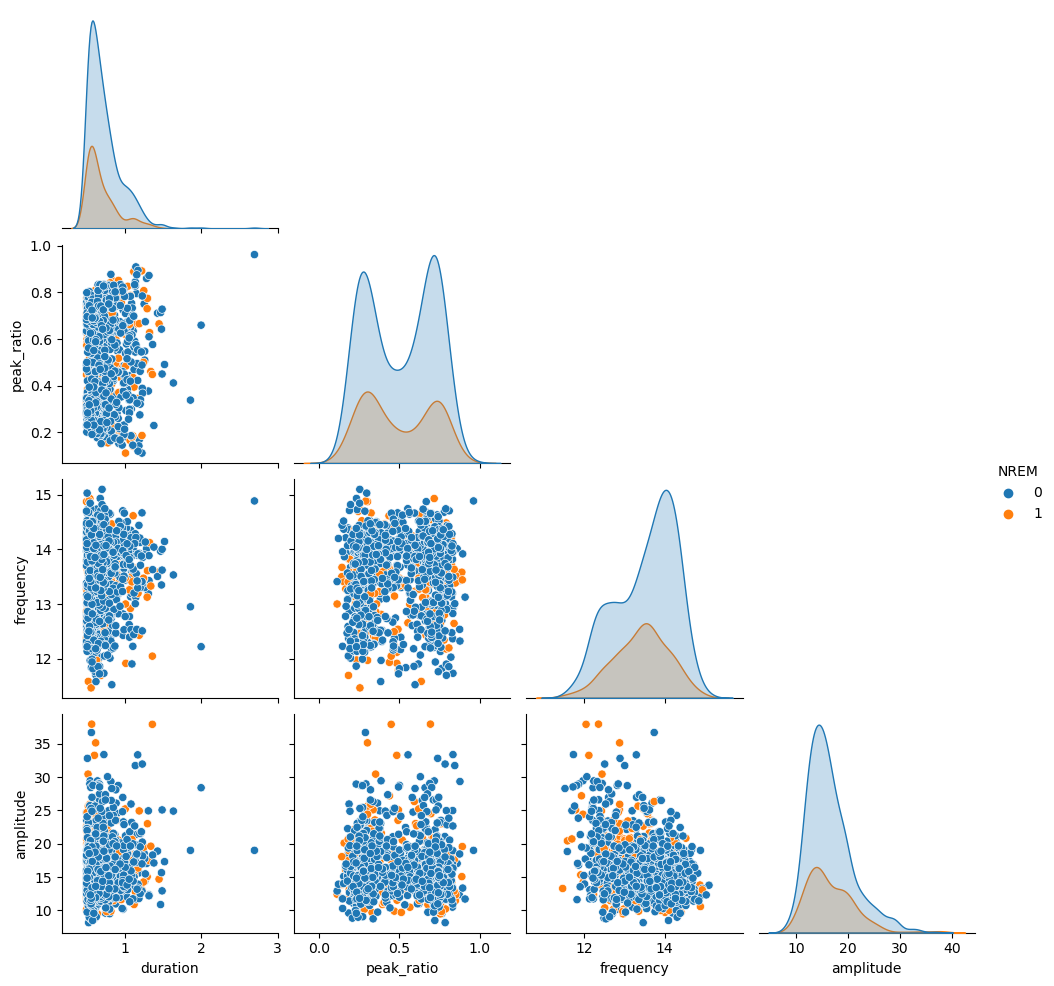

In [7]:
# Scatterplots and distributions split by `NREM`
columns = ['duration', 'peak_ratio', 'frequency', 'amplitude', 'NREM']
_ = sns.pairplot(df[columns], hue='NREM', corner=True)
plt.show()


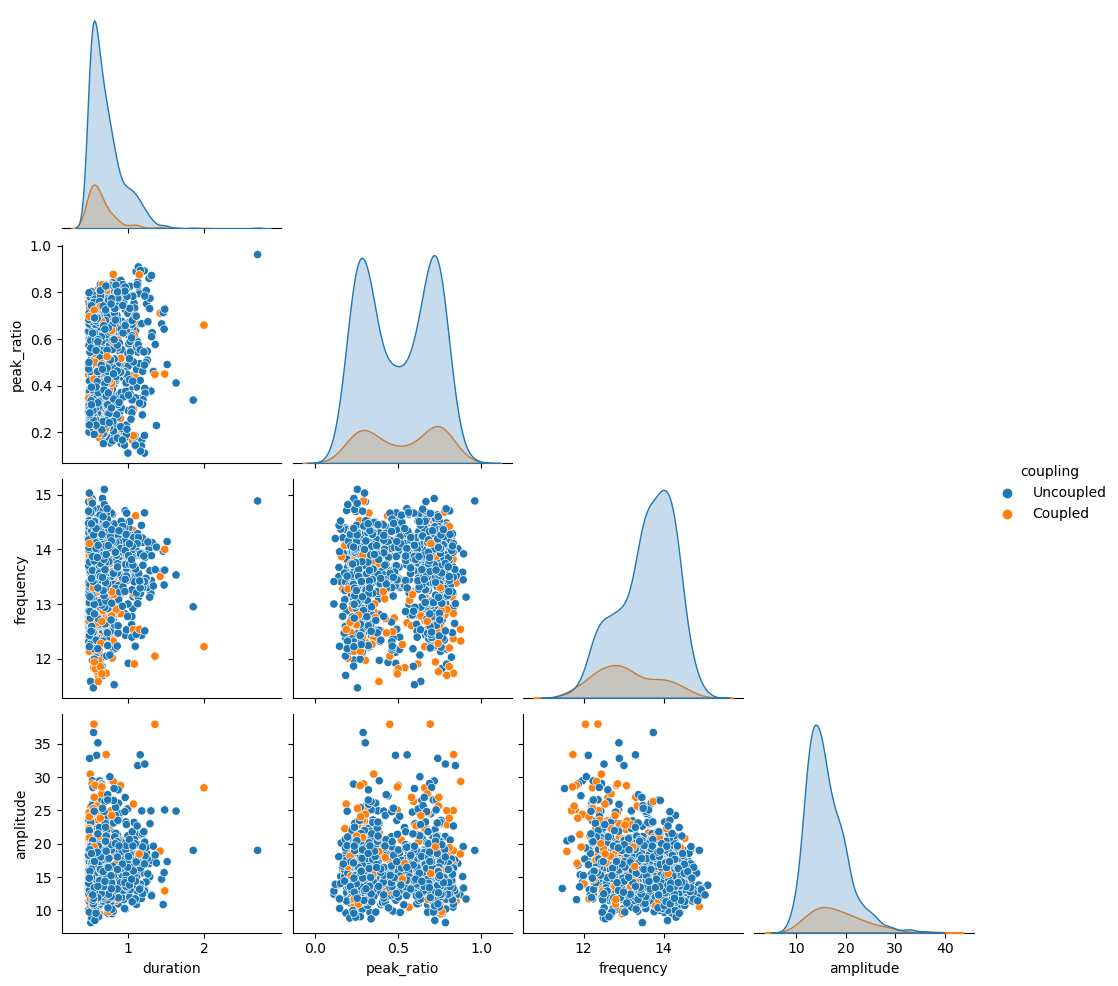

In [8]:
# Scatterplots and distributions split by `type`
columns = ['duration', 'peak_ratio', 'frequency', 'amplitude', 'coupling']
_ = sns.pairplot(df[columns], hue='coupling', corner=True)
plt.show()


### Multicollineary

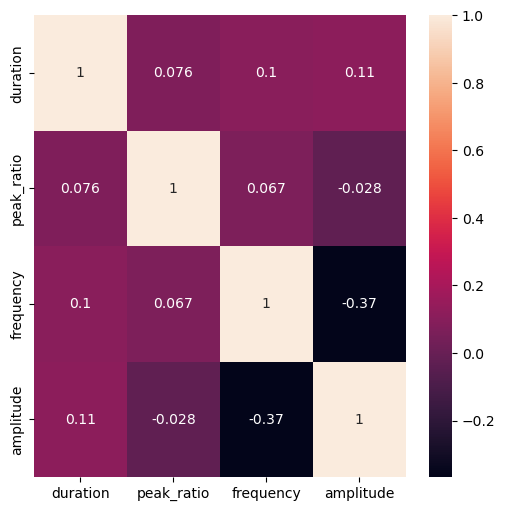

In [9]:
# Correlation matrix

columns = ['duration', 'peak_ratio', 'frequency', 'amplitude']
corr = df[columns].corr()
_ = plt.figure(figsize=(6, 6))
_ = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)


Whereas correlation coefficients calculated earlier can be used to detect collinearity, the Variance Inflation Factor (VIF) is better suited to test for multicollinearity. In this method, each feature is regressed against all other features. The VIF is calculated for each of these linear regression models as follows:
$$
VIF=\frac{1}{1-R^2}
$$

**A Rule of thumb**
- $VIF \approx 1$: no correlation between a given predictor and others
- $ VIF > 4$: moderate correlation, may warrant further investigation 
- $ VIF > 10$: strong multicollinearity, correction is needed

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

columns = ['duration', 'peak_ratio', 'frequency', 'amplitude', 'NREM']

# VIF dataframe
vif_df = pd.DataFrame()
vif_df['feature'] = columns
  
# calculating VIF for each predictor
vif_df['VIF'] = [variance_inflation_factor(df[columns].values, i) for i in range(len(columns))]

display(vif_df)


feature        VIF
0    duration  11.948958
1  peak_ratio   6.694882
2   frequency  24.564177
3   amplitude  12.979817
4        NREM   1.354448

## Modeling

### Utility Functions

In [11]:
# Utility functions

def f_display_regression_model(rm, predictors):
    rm2print = f'y_hat = {rm.intercept_[0]:6.4f}'
    for i in range(len(rm.coef_[0])):
        rm2print += f' + ({rm.coef_[0][i]:6.4f})*{predictors[i]}'
    print(rm2print)

    
def f_display_feature_importance(m, predictors):
    import math
    import pandas as pd
    import matplotlib.pyplot as plt
 
    df_feature_importance = pd.DataFrame(predictors, columns = ["feature"])
    
    # The model is a logistic regression
    # For logistic regression, increase a certain feature by one unit, change the prediction by e to the power of its weight/coefficient
    # We can apply this rule to all weights (coefficients) to determine the feature importance
    # To do so, I will calculate the Euler number to the power of its coefficient to find the importance
    if isinstance(m, LogisticRegression):
        print('\nLogistic regression: the Euler number to the power of each weight is considered.')
        importance = pow(math.e, m.coef_[0])
    
    # Any other regression model
    elif hasattr(m, 'coef_'):
        importance = m.coef_[0]
    
    # Classifier
    else:
        importance = m.feature_importances_
    
    df_feature_importance["importance"] = importance
    df_feature_importance = df_feature_importance.sort_values(by = ["importance"], ascending=False).reset_index(drop=True)
    display(df_feature_importance)
    
    # Plot
    fig, ax = plt.subplots()
    ax.barh(y=df_feature_importance['feature'], width=df_feature_importance['importance'])
    
    # Remove the top and right spine
    ax.spines[['top', 'right']].set_visible(False)
    
    ax.set_xlabel('Importance')
    ax.set_ylabel('')
    
    plt.show()  
    
    
def f_display_confusion_matrix(y, y_hat, target_names):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt
    
    cm = confusion_matrix(y, y_hat)
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    cm_disp.plot()
    plt.show()
    
    
def f_get_binarized(y_train, y_test):
    from sklearn.preprocessing import LabelBinarizer
    
    # --- Binarize the target `y_test` by one-hot-encoding in a one-vs-rest fashion
    # The procedure maps the target of shape (`n_samples`) to a target of shape (`n_samples`, `n_classes`)
    label_binarizer = LabelBinarizer().fit(y_train)
    target_names = label_binarizer.classes_
    y_test_onehot = label_binarizer.transform(y_test)

    # Add a column for the zero class; is needed to match the shape of prediction scores if there are only two classes
    if y_test_onehot.shape[1] == 1:
        c2add = np.array([0 if val==1 else 1 for val in y_test_onehot.sum(axis=1)]).reshape(-1, 1)
        y_test_onehot = np.hstack((c2add, y_test_onehot))
    
    return target_names, y_test_onehot
    
    
def f_display_roc_auc(y_train, y_test, y_test_score):
    # (https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)
    from sklearn import metrics
    import matplotlib.pyplot as plt
    
    # --- Binarize the target `y_test` by one-hot-encoding in a one-vs-rest fashion
    # The procedure maps the target of shape (`n_samples`) to a target of shape (`n_samples`, `n_classes`)
    target_names, y_test_onehot = f_get_binarized(y_train, y_test)

    # --- Compute ROC curve and ROC area
    
    # Store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()

    # Micro-averaging - is preferable with highly imbalanced classes 
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test_onehot.ravel(), y_test_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

    # Macro-averaging - all classes are treated equally a priori
    for i_class in range(len(target_names)):
        fpr[i_class], tpr[i_class], _ = metrics.roc_curve(y_test_onehot[:, i_class], y_test_score[:, i_class])
        roc_auc[i_class] =  metrics.auc(fpr[i_class], tpr[i_class])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i_class in range(len(target_names)):
        mean_tpr += np.interp(fpr_grid, fpr[i_class], tpr[i_class])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= len(target_names)

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] =  metrics.auc(fpr["macro"], tpr["macro"])

    # --- Plot one-vs-rest ROC curves for each target class
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"Micro-average (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle="dotted",
        linewidth=2,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"Macro-average (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle="dotted",
        linewidth=2,
    )
    
    for i_class in range(len(target_names)):
        metrics.RocCurveDisplay.from_predictions(
            y_test_onehot[:, i_class],
            y_test_score[:, i_class],
            name=(f'{target_names[i_class]}, OvR'),
            ax=ax,
        )

    plt.plot([0, 1],
             [0, 1],
             label="Chance level (AUC = 0.5)",
             color="gray",
             linestyle="-",
             linewidth=0.5,
             )
    
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc='lower right', bbox_to_anchor=(1.6, 0))
    plt.show()

    
def f_display_roc_auc_micro(y_onehot, y_scores):
    from sklearn import metrics
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(6, 6))

    for model, y_score in y_scores.items():
        metrics.RocCurveDisplay.from_predictions(
        y_onehot.ravel(),
        y_score.ravel(),
        name=model,
            ax=ax,
        )
    
    plt.plot([0, 1],
             [0, 1],
             label="Chance level (AUC = 0.5)",
             color="gray",
             linestyle="-",
             linewidth=0.5,
             )

    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
    plt.legend(loc='lower right', bbox_to_anchor=(1.6, 0))
    plt.show()
    

### Binary Classification

Two target classes:
- Coupled
- Uncoupled

In [12]:
# Predictors and response variables

predictors = ['duration', 'peak_ratio', 'frequency', 'amplitude', 'NREM']
X = df[predictors]

target = ['coupling'] 
y = df[target].values.ravel()

In [13]:
# Split data into training and test sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 


#### Logistic Regression

**Approach**

1. Create a base model by fitting the logistic regession using the default parameters
2. Use balanced `class_weights` and determine for the best `solver` using the `GreadSearchCV` object
4. Create a model using the best solver and `LogisticRegressionCV` object
3. Apply PCA to see if the transformation may improve the performance of the model fitted using the best parameters

Performance of the models is evaluated using previously unseen observations (i.e., the test set)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

y_hat = 1.8585 + (0.2456)*duration + (-0.1710)*peak_ratio + (0.4863)*frequency + (-0.3071)*amplitude + (-0.2652)*NREM

Logistic regression: the Euler number to the power of each weight is considered.


feature  importance
0   frequency    1.626356
1    duration    1.278449
2  peak_ratio    0.842786
3        NREM    0.767085
4   amplitude    0.735551

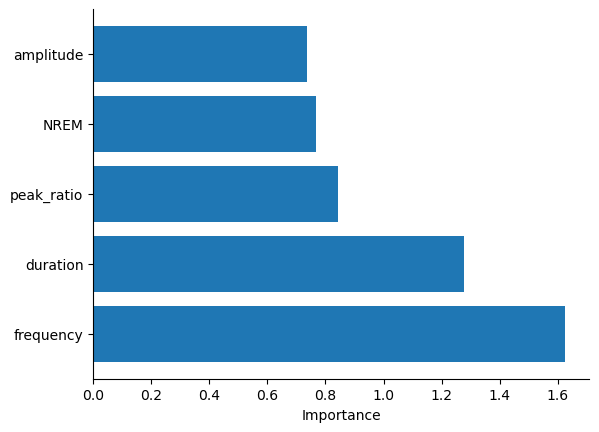

In [14]:
# Logistic regression

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
    
# Train with the default parameters: penalty='l2', solver='lbfgs', class_weight=None -> all classes have weight one
# Is used as a baseline/reference model

# Make the pipeline
pipe_logreg_base = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
display(pipe_logreg_base)

# Fit the model
pipe_logreg_base.fit(X_train, y_train)

# Show the model
logreg_base = pipe_logreg_base['logisticregression']
f_display_regression_model(logreg_base, predictors)
f_display_feature_importance(logreg_base, predictors)


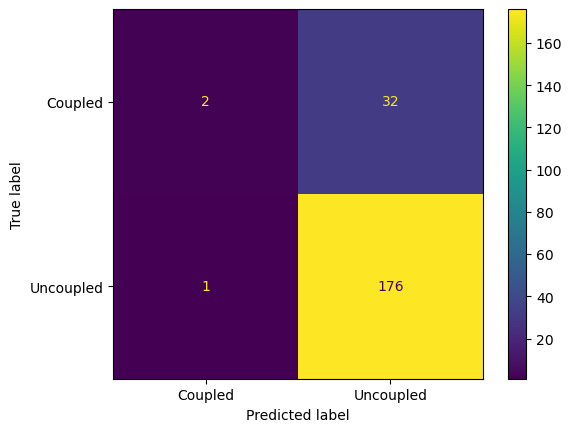

              precision    recall  f1-score   support

     Coupled     0.6667    0.0588    0.1081        34
   Uncoupled     0.8462    0.9944    0.9143       177

    accuracy                         0.8436       211
   macro avg     0.7564    0.5266    0.5112       211
weighted avg     0.8172    0.8436    0.7844       211



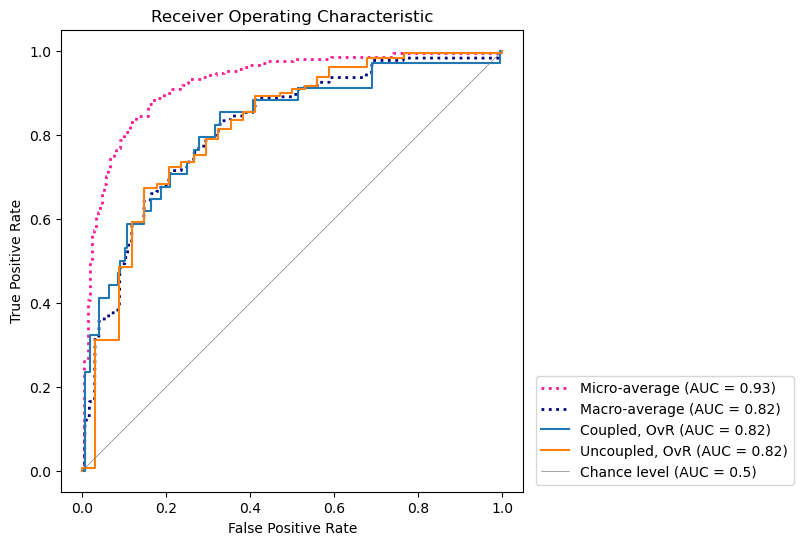

In [15]:
# Evaluate performace on the test set
y_test_hat = pipe_logreg_base.predict(X_test)
y_test_score = pipe_logreg_base.predict_proba(X_test)
target_names = pipe_logreg_base.classes_

# Display confusion matrix
f_display_confusion_matrix(y_test, y_test_hat, target_names)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat, digits=4))

# Display ROC & AUC
f_display_roc_auc(y_train, y_test, y_test_score)


**Macro-average**
- The metric is computed independently for each class and then averaged
- Gives equal weight for class

**Micro-average**
- First, the true positives and false positives are aggregated across all classes, and then the metric is computed
- Gives equal weight for each sample/observation
- is preferable with highly imbalanced classes

Despite a high score for accuracy (= 0.8436), the f1-score for the coupled spindles is quite low (=0.1081). That is probably because the data is highly imbalanced.

In [16]:
print(f'The number of coupled spindles in the training set: {sum(y_train == "Coupled")}')
print(f'the number of uncoupled spindles in the training set: {sum(y_train == "Uncoupled")}')

The number of coupled spindles in the training set: 134
the number of uncoupled spindles in the training set: 709


Indeed, we are dealing with imbalanced data. In such cases, using standard machine learning methods like logistic regression may result in poor performance, with the classifier tending to favor the majority class. Therefore, we need to use a weighted logistic regression and give more weight to the minority class. We can do so by passing to `LogisticRegression` `class_weight=balanced`. We can also test different solvers and determine which one is the best.

To evaluate the performance of the model, F1-score is used.


In [17]:
# Tuning parameters with `GridSearchCV`

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Make a pipeline
pipe_logreg = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', random_state=42))
display(pipe_logreg)

# Set parameters to tune
solver_list = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
param_grid ={
    'logisticregression__solver': solver_list,
}

# Do the search
# If the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used
grid_search = GridSearchCV(
    estimator=pipe_logreg,
    scoring='f1_micro',    
    param_grid=param_grid,
    n_jobs=-1, # The number of jobs to run in parallel; -1: use all processors
    cv=5,
)
grid_search.fit(X_train, y_train)

# Results
scoring = grid_search.get_params()['scoring']
if scoring is None:
    scoring = 'accuracy'
scores = grid_search.cv_results_['mean_test_score']

print(f'\n {scoring} scores:\n')
for score, solver in zip(scores, solver_list):
    print(f" {solver:<20} {score:.4f}" )

print(f'\nThe best {scoring} score: {grid_search.best_score_:.4f}')
print('\nThe best parameters:\n', (grid_search.best_params_))


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', random_state=42))])


 f1_micro scores:

 lbfgs                0.6490
 liblinear            0.6478
 newton-cg            0.6490
 newton-cholesky      0.6490
 sag                  0.6490
 saga                 0.6490

The best f1_micro score: 0.6490

The best parameters:
 {'logisticregression__solver': 'lbfgs'}


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(class_weight='balanced', cv=5,
                                      random_state=42))])

y_hat = 0.0357 + (0.0320)*duration + (-0.0119)*peak_ratio + (0.0827)*frequency + (-0.0652)*amplitude + (-0.0398)*NREM

Logistic regression: the Euler number to the power of each weight is considered.


feature  importance
0   frequency    1.086176
1    duration    1.032503
2  peak_ratio    0.988158
3        NREM    0.961014
4   amplitude    0.936844

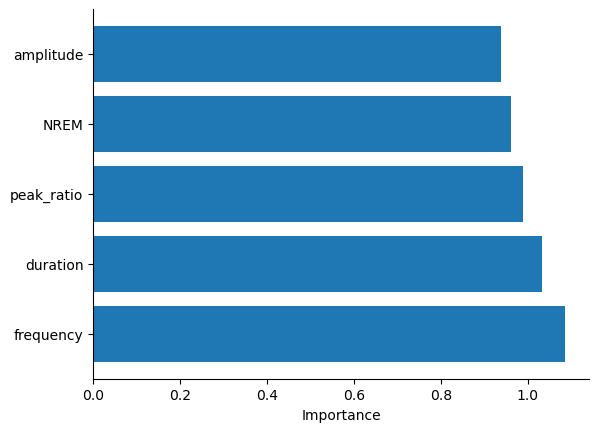

In [18]:
# The best logistic regression model using cross validation

from sklearn.linear_model import LogisticRegressionCV
    
# Make the pipeline
logreg_cv = LogisticRegressionCV(cv=5, penalty='l2', solver='lbfgs', class_weight='balanced', random_state=42)
pipe_logreg_best = make_pipeline(StandardScaler(), logreg_cv)
display(pipe_logreg_best)

# Fit the model
pipe_logreg_best.fit(X_train, y_train)

# Show the model
logreg_best = pipe_logreg_best['logisticregressioncv']
f_display_regression_model(logreg_best, predictors)
f_display_feature_importance(logreg_best, predictors)


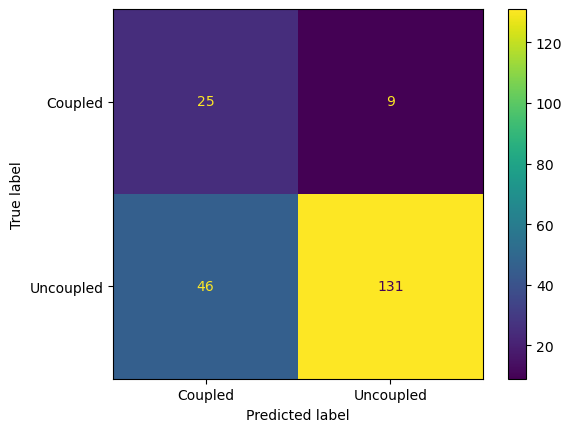

              precision    recall  f1-score   support

     Coupled     0.3521    0.7353    0.4762        34
   Uncoupled     0.9357    0.7401    0.8265       177

    accuracy                         0.7393       211
   macro avg     0.6439    0.7377    0.6513       211
weighted avg     0.8417    0.7393    0.7701       211



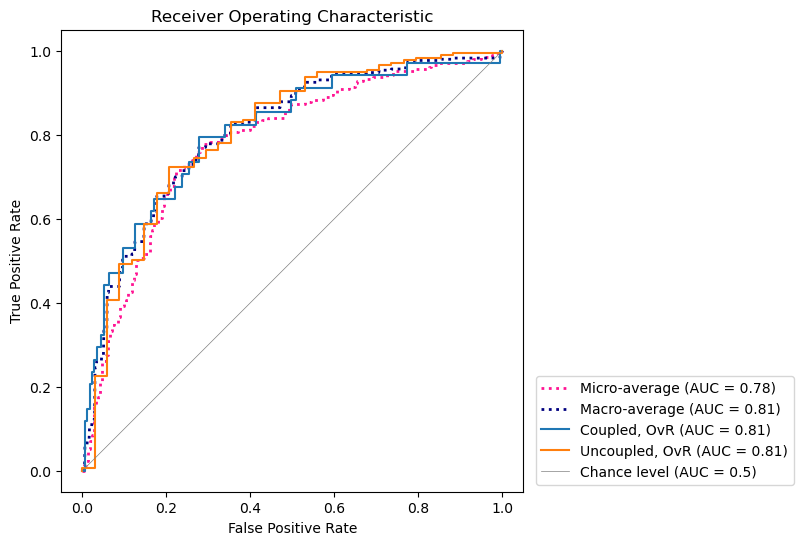

In [19]:
# Evaluate performace on the test set
y_test_hat = pipe_logreg_best.predict(X_test)
y_test_score = pipe_logreg_best.predict_proba(X_test)
target_names = pipe_logreg_best.classes_

# Display confusion matrix
f_display_confusion_matrix(y_test, y_test_hat, target_names)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat, digits=4))

# Display ROC & AUC
f_display_roc_auc(y_train, y_test, y_test_score)



 THE BASE MODEL
              precision    recall  f1-score   support

     Coupled     0.6667    0.0588    0.1081        34
   Uncoupled     0.8462    0.9944    0.9143       177

    accuracy                         0.8436       211
   macro avg     0.7564    0.5266    0.5112       211
weighted avg     0.8172    0.8436    0.7844       211


 THE BEST MODEL
              precision    recall  f1-score   support

     Coupled     0.3521    0.7353    0.4762        34
   Uncoupled     0.9357    0.7401    0.8265       177

    accuracy                         0.7393       211
   macro avg     0.6439    0.7377    0.6513       211
weighted avg     0.8417    0.7393    0.7701       211



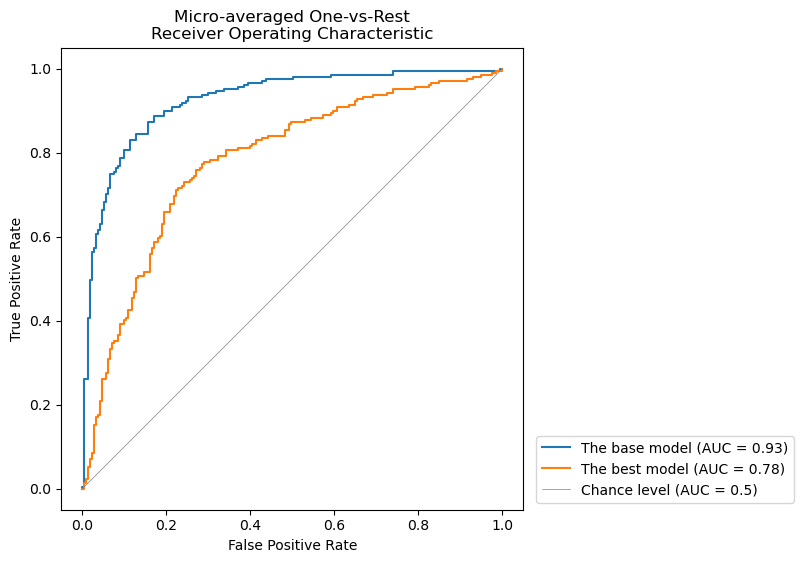

In [20]:
# Compare models

# --- Classification report

from sklearn.metrics import classification_report

# Calculate predicted values for the base and the best model
y_hats = {
    'The base model': pipe_logreg_base.predict(X_test),
    'The best model': pipe_logreg_best.predict(X_test),
}

for model, y_hat in y_hats.items():
    print('\n', model.upper())
    print(classification_report(y_test, y_hat, digits=4))


# --- ROC & AUC

from sklearn import metrics
import matplotlib.pyplot as plt
    
# Binarize the target `y_test` by one-hot-encoding in a one-vs-rest fashion
# The procedure maps the target of shape (`n_samples`) to a target of shape (`n_samples`, `n_classes`)
target_names, y_test_onehot = f_get_binarized(y_train, y_test)

# Calculate scores for the base and the best model
y_test_scores = {
    'The base model': pipe_logreg_base.predict_proba(X_test),
    'The best model': pipe_logreg_best.predict_proba(X_test),
}

# Plot
f_display_roc_auc_micro(y_test_onehot, y_test_scores)


In [21]:
# Model with the PCA-transformed variables

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
    
# Make the pipeline
logreg = LogisticRegression(penalty='l2', solver='lbfgs', class_weight='balanced', random_state=42)
pipe_pca_logreg = make_pipeline(StandardScaler(), PCA(), logreg)
display(pipe_pca_logreg)

# Set parameters to tune
n_components_list = list(np.arange(2, len(predictors) + 1))
param_grid ={
    'pca__n_components': n_components_list,
}

# Do the search
# If the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used
grid_search = GridSearchCV(
    estimator=pipe_pca_logreg,
    scoring='f1_micro',    
    param_grid=param_grid,
    n_jobs=-1, # The number of jobs to run in parallel; -1: all processors
    cv=5,
)
grid_search.fit(X_train, y_train)

# Results
scoring = grid_search.get_params()['scoring']
if scoring is None:
    scoring = 'accuracy'
scores = grid_search.cv_results_['mean_test_score']

print(f'\n{scoring} scores:\n')
for score, n_components in zip(scores, n_components_list):
    print(f'PCA with {n_components} components {score:10.4f}')

print(f'\nThe best {scoring} score: {grid_search.best_score_:.4f}')
print('\nThe best parameters:\n', (grid_search.best_params_))


Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', random_state=42))])


f1_micro scores:

PCA with 2 components     0.6632
PCA with 3 components     0.6561
PCA with 4 components     0.6573
PCA with 5 components     0.6490

The best f1_micro score: 0.6632

The best parameters:
 {'pca__n_components': 2}


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2))])

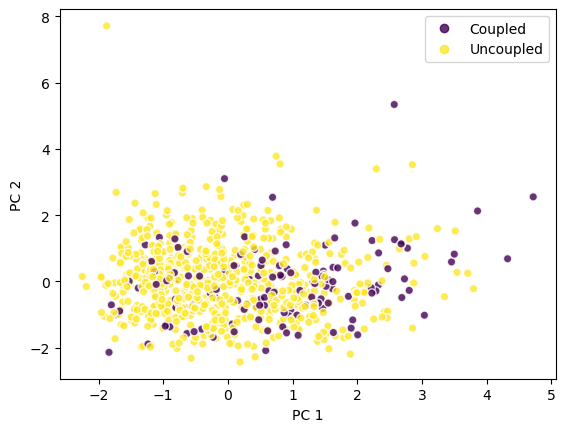

In [22]:
# Visualize PCs

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt

# Make the pipeline
pipe_pca = make_pipeline(StandardScaler(), PCA(n_components=2))
display(pipe_pca)

# Transform the data
X_train_pca = pipe_pca.fit_transform(X_train)

# Plot
target_names = ['Coupled', 'Uncoupled']
colors = [0 if y == target_names[0] else 1 for y in y_train]
ax = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=colors, edgecolors='white', alpha=0.8)
plt.legend(handles=ax.legend_elements()[0], labels=target_names)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()


y_hat = 0.0936 + (-0.3403)*pc1 + (0.0846)*pc2

Logistic regression: the Euler number to the power of each weight is considered.


feature  importance
0     pc2    1.088303
1     pc1    0.711589

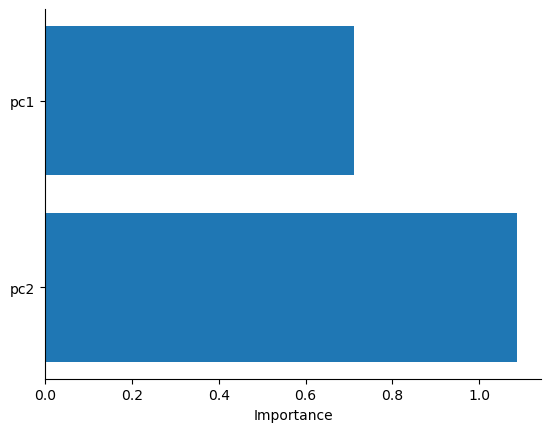

In [23]:
# The model with the best parameters using principle components and cross validation

from sklearn.linear_model import LogisticRegressionCV

# Fit the model
pca_logreg_cv = LogisticRegressionCV(cv=5, penalty='l2', solver='lbfgs', class_weight='balanced', random_state=42)
pca_logreg_cv.fit(X_train_pca, y_train)

# Show the model
f_display_regression_model(pca_logreg_cv, ['pc1', 'pc2'])
f_display_feature_importance(pca_logreg_cv, ['pc1', 'pc2'])


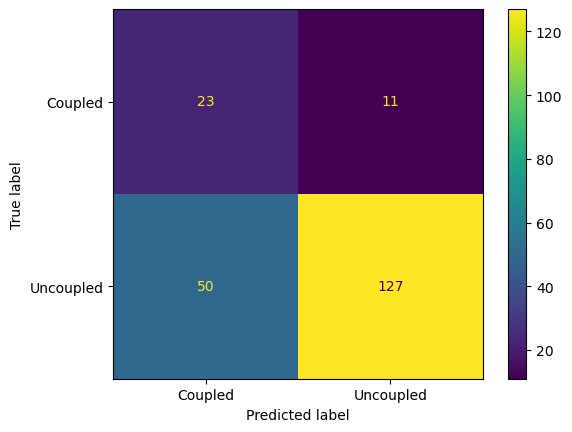

              precision    recall  f1-score   support

     Coupled     0.3151    0.6765    0.4299        34
   Uncoupled     0.9203    0.7175    0.8063       177

    accuracy                         0.7109       211
   macro avg     0.6177    0.6970    0.6181       211
weighted avg     0.8228    0.7109    0.7457       211



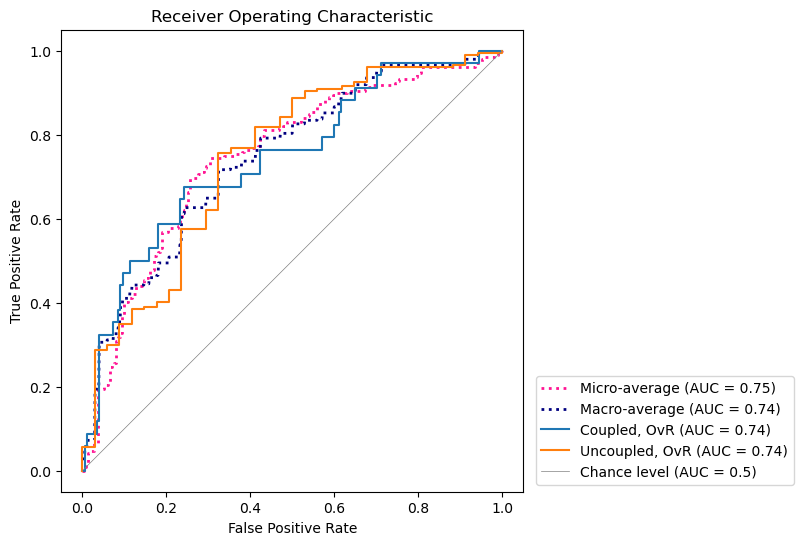

In [24]:
# Evaluate performace on the test set

# Get principle components for the test set
X_test_pca = pipe_pca.transform(X_test)

y_test_hat = pca_logreg_cv.predict(X_test_pca)
y_test_score = pca_logreg_cv.predict_proba(X_test_pca)
target_names = pca_logreg_cv.classes_

# Display confusion matrix
f_display_confusion_matrix(y_test, y_test_hat, target_names)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat, digits=4))

# Display ROC & AUC
f_display_roc_auc(y_train, y_test, y_test_score)


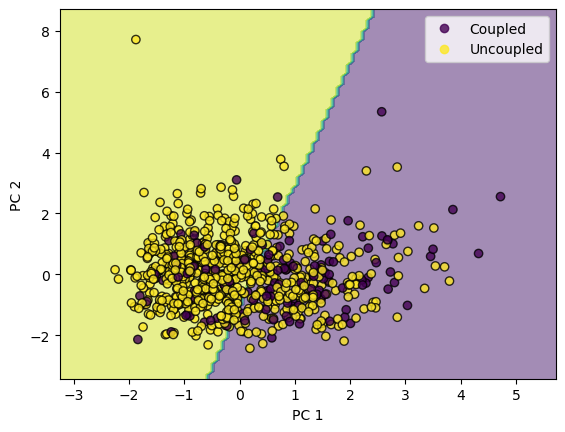

In [25]:
# Visualize decision boundaries

from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

target_names = ['Coupled', 'Uncoupled']
colors = [0 if y == target_names[0] else 1 for y in y_train]

disp = DecisionBoundaryDisplay.from_estimator(
    pca_logreg_cv,
    X_train_pca,
    response_method="predict",
    xlabel='PC 1', ylabel='PC 2',
    alpha=0.5,
)

ax = disp.ax_.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=colors, edgecolor='k', alpha=0.8)
disp.ax_.legend(handles=ax.legend_elements()[0], labels=target_names)
plt.show()



 THE BASE MODEL
              precision    recall  f1-score   support

     Coupled     0.6667    0.0588    0.1081        34
   Uncoupled     0.8462    0.9944    0.9143       177

    accuracy                         0.8436       211
   macro avg     0.7564    0.5266    0.5112       211
weighted avg     0.8172    0.8436    0.7844       211


 THE BEST MODEL
              precision    recall  f1-score   support

     Coupled     0.3521    0.7353    0.4762        34
   Uncoupled     0.9357    0.7401    0.8265       177

    accuracy                         0.7393       211
   macro avg     0.6439    0.7377    0.6513       211
weighted avg     0.8417    0.7393    0.7701       211


 THE BEST MODEL WITH PCS
              precision    recall  f1-score   support

     Coupled     0.3151    0.6765    0.4299        34
   Uncoupled     0.9203    0.7175    0.8063       177

    accuracy                         0.7109       211
   macro avg     0.6177    0.6970    0.6181       211
weighted avg  

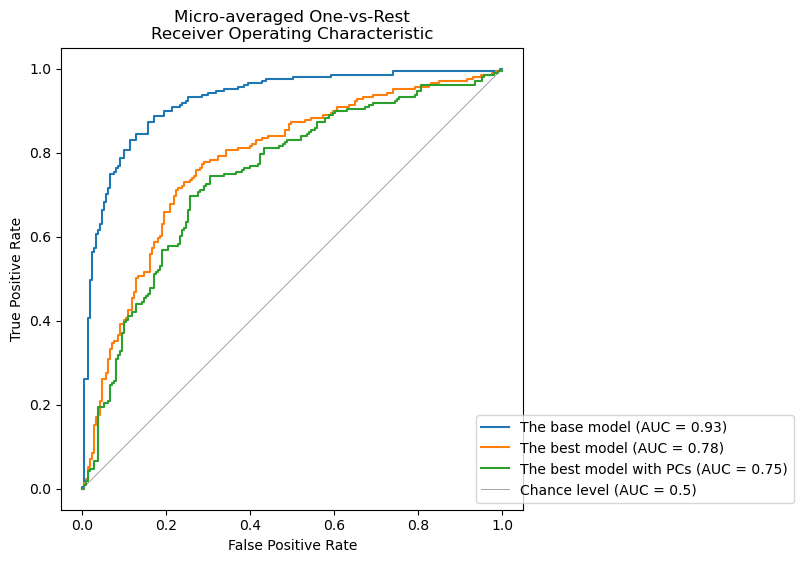

In [26]:
# Compare models

# --- Classification report

from sklearn.metrics import classification_report

# Calculate predicted values for the base and the best model
y_hats = {
    'The base model': pipe_logreg_base.predict(X_test),
    'The best model': pipe_logreg_best.predict(X_test),
    'The best model with PCs': pca_logreg_cv.predict(X_test_pca),    
}

for model, y_hat in y_hats.items():
    print('\n', model.upper())
    print(classification_report(y_test, y_hat, digits=4))


# --- ROC & AUC

from sklearn import metrics
import matplotlib.pyplot as plt
    
# Binarize the target `y_test` by one-hot-encoding in a one-vs-rest fashion
# The procedure maps the target of shape (`n_samples`) to a target of shape (`n_samples`, `n_classes`)
target_names, y_test_onehot = f_get_binarized(y_train, y_test)

# Calculate scores for the base and the best model
y_test_scores = {
    'The base model': pipe_logreg_base.predict_proba(X_test),
    'The best model': pipe_logreg_best.predict_proba(X_test),
    'The best model with PCs': pca_logreg_cv.predict_proba(X_test_pca),
}

# Plot
f_display_roc_auc_micro(y_test_onehot, y_test_scores)


#### Random Forest

**Approach**

1. Build a base tree using `DecisionTreeClassifier` with the default parameters
2. Determine the best parameters for `RandomForestClassifier` using the `GreadSearchCV` object
3. Create a classifier using `RandomForestClassifier` with the best parameters

Performance of the models is evaluated using previously unseen observations (i.e., the test set)

DecisionTreeClassifier(random_state=42)

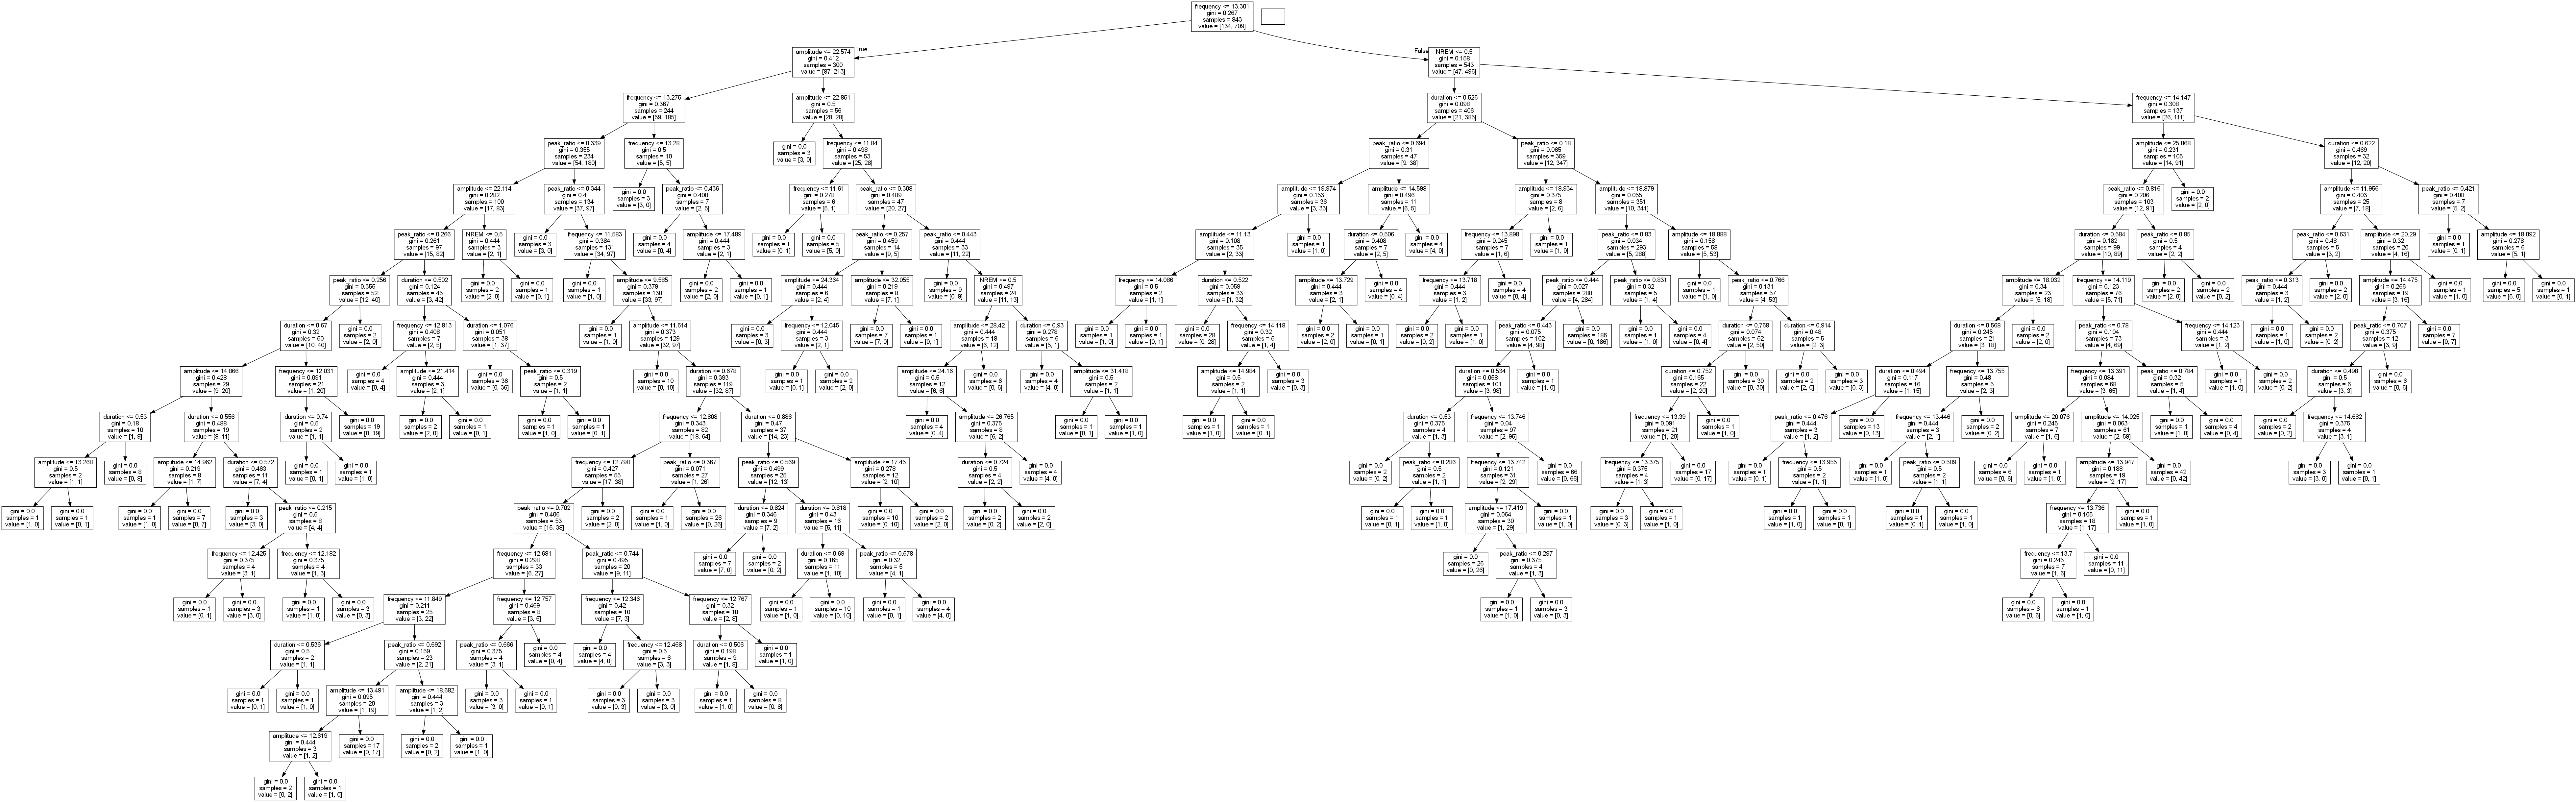

In [27]:
# Decision tree

# --- Train with the default parameters
from sklearn.tree import DecisionTreeClassifier

# The parameters: criterion='gini', min_samples_split=2 with nodes expanded until all leaves contain less than two samples and
# unlimited number of leaf nodes.
# Is used as a baseline/reference model
dtc = DecisionTreeClassifier(random_state=42)
display(dtc)
dtc.fit(X_train, y_train)

# --- Show the model
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

# Create DOT data and show
dot_data = export_graphviz(dtc, out_file = None, feature_names =predictors)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())


feature  importance
0   frequency    0.277606
1   amplitude    0.269373
2  peak_ratio    0.240489
3    duration    0.179310
4        NREM    0.033221

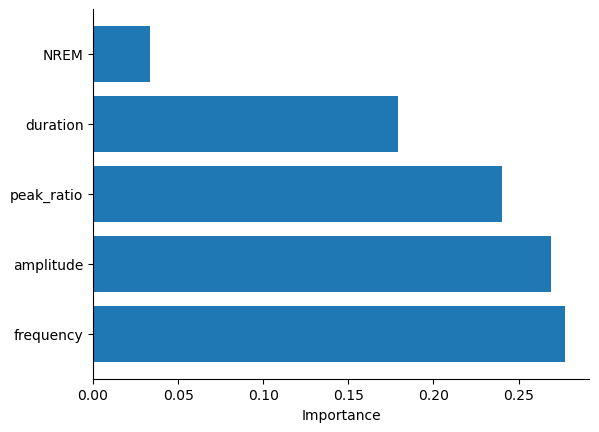

In [28]:
# Feature importnace
f_display_feature_importance(dtc, predictors)


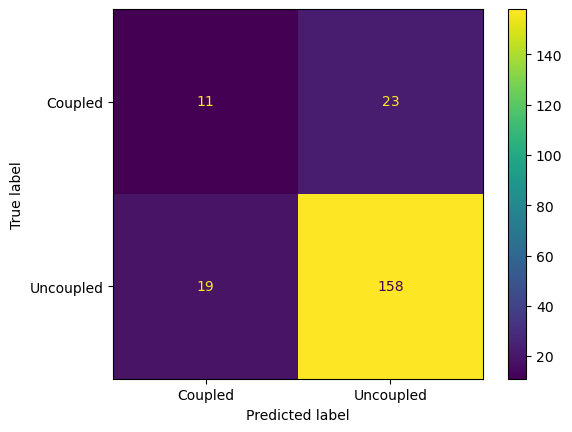

              precision    recall  f1-score   support

     Coupled     0.3667    0.3235    0.3438        34
   Uncoupled     0.8729    0.8927    0.8827       177

    accuracy                         0.8009       211
   macro avg     0.6198    0.6081    0.6132       211
weighted avg     0.7914    0.8009    0.7958       211



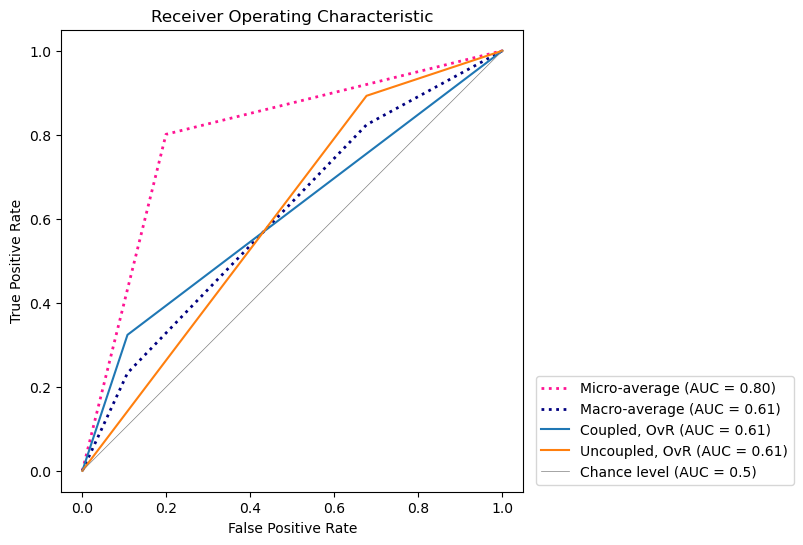

In [29]:
# Evaluate performace on the test set

y_test_hat = dtc.predict(X_test)
y_test_score = dtc.predict_proba(X_test)
target_names = dtc.classes_

# Display confusion matrix
f_display_confusion_matrix(y_test, y_test_hat, target_names)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat, digits=4))

# Display ROC & AUC
f_display_roc_auc(y_train, y_test, y_test_score)


In [30]:
# Tuning parameters for `RandomForestClassifier` with `GridSearchCV`

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Set parameters to tune
solver_list = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
param_grid ={
    'n_estimators': [25, 50, 100, 200],
    'max_features': ['sqrt', 'log2'], # Number of features to consider at every split
    'max_depth': [10, 20, None],
    'criterion': ['gini', 'entropy'],
    'max_leaf_nodes': [3, 6, 9, None],
}

# Do the search
# If the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    scoring='f1_micro',    
    param_grid=param_grid,
    n_jobs=-1, # The number of jobs to run in parallel; -1: use all processors
    cv=5,
)
grid_search.fit(X_train, y_train)

# Results
scoring = grid_search.get_params()['scoring']
if scoring is None:
    scoring = 'accuracy'
scores = grid_search.cv_results_['mean_test_score']

print(f'\n {scoring} scores:\n')
print(scores)

print(f'\nThe best {scoring} score: {grid_search.best_score_:.4f}')
print('\nThe best parameters:\n', (grid_search.best_params_))



 f1_micro scores:

[0.84104677 0.84104677 0.84104677 0.84104677 0.83747535 0.83866582
 0.83865878 0.83865878 0.84220907 0.83865878 0.83628487 0.83628487
 0.82323894 0.83391801 0.83034658 0.83036066 0.84104677 0.84104677
 0.84104677 0.84104677 0.83747535 0.83866582 0.83865878 0.83865878
 0.84220907 0.83865878 0.83628487 0.83628487 0.82323894 0.83391801
 0.83034658 0.83036066 0.84104677 0.84104677 0.84104677 0.84104677
 0.83747535 0.83866582 0.83865878 0.83865878 0.84220907 0.83865878
 0.83628487 0.83628487 0.82326007 0.82564103 0.82681741 0.82443646
 0.84104677 0.84104677 0.84104677 0.84104677 0.83747535 0.83866582
 0.83865878 0.83865878 0.84220907 0.83865878 0.83628487 0.83628487
 0.82326007 0.82564103 0.82681741 0.82443646 0.84104677 0.84104677
 0.84104677 0.84104677 0.83747535 0.83866582 0.83865878 0.83865878
 0.84220907 0.83865878 0.83628487 0.83628487 0.82445055 0.82445759
 0.82800789 0.82325303 0.84104677 0.84104677 0.84104677 0.84104677
 0.83747535 0.83866582 0.83865878 0.838658

In [31]:
# Create the best tree using `RandomForestClassifier` with the best parameters

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(
    n_estimators=25,
    criterion='gini',
    max_depth=10,
    max_features='sqrt',
    max_leaf_nodes=9,
    random_state=42,
)

rfc.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, max_leaf_nodes=9, n_estimators=25,
                       random_state=42)

feature  importance
0   frequency    0.326345
1   amplitude    0.309956
2  peak_ratio    0.165877
3    duration    0.158177
4        NREM    0.039646

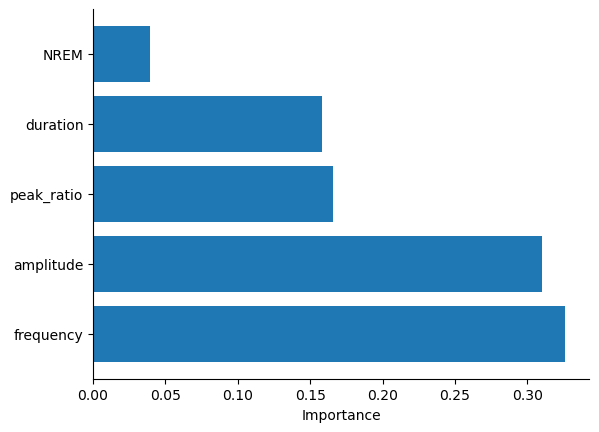

In [32]:
# Feature importnace
f_display_feature_importance(rfc, predictors)


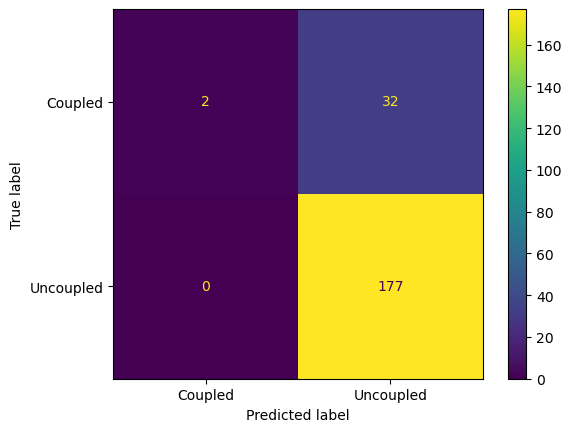

              precision    recall  f1-score   support

     Coupled     1.0000    0.0588    0.1111        34
   Uncoupled     0.8469    1.0000    0.9171       177

    accuracy                         0.8483       211
   macro avg     0.9234    0.5294    0.5141       211
weighted avg     0.8716    0.8483    0.7872       211



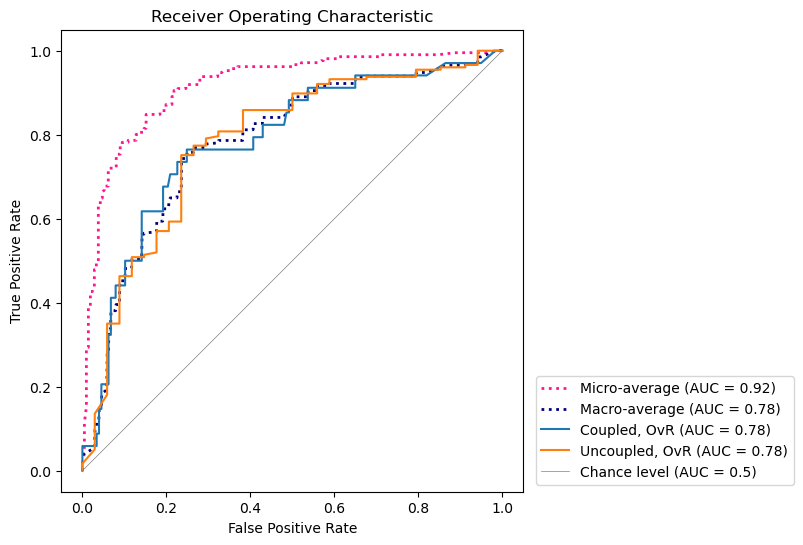

In [33]:
# Evaluate performace on the test set

y_test_hat = rfc.predict(X_test)
y_test_score = rfc.predict_proba(X_test)
target_names = rfc.classes_

# Display confusion matrix
f_display_confusion_matrix(y_test, y_test_hat, target_names)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat, digits=4))

# Display ROC & AUC
f_display_roc_auc(y_train, y_test, y_test_score)



 DECISION TREE
              precision    recall  f1-score   support

     Coupled     0.3667    0.3235    0.3438        34
   Uncoupled     0.8729    0.8927    0.8827       177

    accuracy                         0.8009       211
   macro avg     0.6198    0.6081    0.6132       211
weighted avg     0.7914    0.8009    0.7958       211


 THE BEST RANDOM FOREST
              precision    recall  f1-score   support

     Coupled     1.0000    0.0588    0.1111        34
   Uncoupled     0.8469    1.0000    0.9171       177

    accuracy                         0.8483       211
   macro avg     0.9234    0.5294    0.5141       211
weighted avg     0.8716    0.8483    0.7872       211



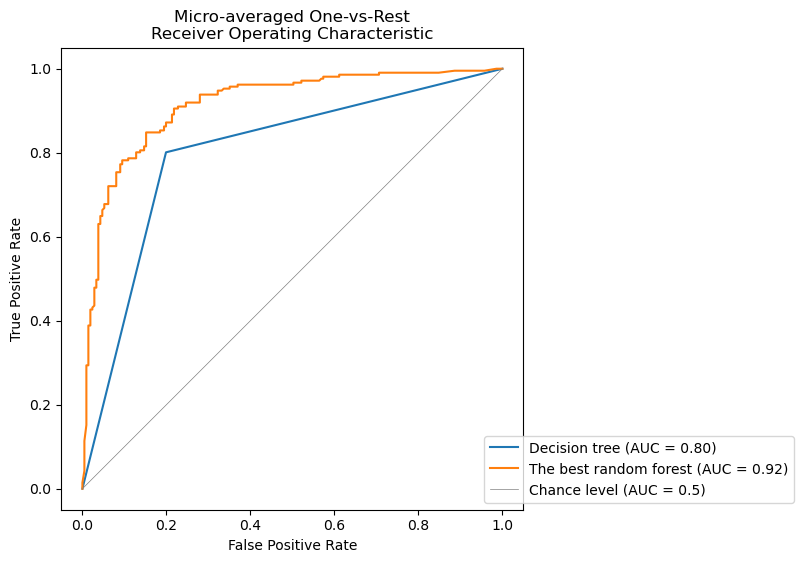

In [34]:
# Compare models

# --- Classification report

from sklearn.metrics import classification_report

# Calculate predicted values for the base and the best model
y_hats = {
    'Decision tree': dtc.predict(X_test),
    'The best random forest': rfc.predict(X_test),
}

for model, y_hat in y_hats.items():
    print('\n', model.upper())
    print(classification_report(y_test, y_hat, digits=4))


# --- ROC & AUC

from sklearn import metrics
import matplotlib.pyplot as plt
    
# Binarize the target `y_test` by one-hot-encoding in a one-vs-rest fashion
# The procedure maps the target of shape (`n_samples`) to a target of shape (`n_samples`, `n_classes`)
target_names, y_test_onehot = f_get_binarized(y_train, y_test)

# Calculate scores for the base and the best model
y_test_scores = {
    'Decision tree': dtc.predict_proba(X_test),
    'The best random forest': rfc.predict_proba(X_test),
}

# Plot
f_display_roc_auc_micro(y_test_onehot, y_test_scores)


### Multi-Class Classification

The channel of the spindle is the target (5 classes).


In [35]:
# Predictors and response variables

predictors = ['duration', 'peak_ratio', 'frequency', 'amplitude', 'NREM']
X = df[predictors]

target = ['channel'] 
y = df[target].values.ravel()

In [36]:
# Split data into training and test sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 


#### Logistic Regression

**Approach**

1. Create a base model by fitting the logistic regession using the default parameters
2. Use balanced `class_weights` and determine for the best `solver` using the `GreadSearchCV` object
4. Create a model using the best solver and `LogisticRegressionCV` object
3. Apply PCA to see if the transformation may improve the performance of the model fitted using the best parameters

Performance of the models is evaluated using previously unseen observations (i.e., the test set)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

y_hat = 0.0274 + (-0.0872)*duration + (0.2042)*peak_ratio + (0.6511)*frequency + (0.4259)*amplitude + (0.0034)*NREM

Logistic regression: the Euler number to the power of each weight is considered.


feature  importance
0   frequency    1.917680
1   amplitude    1.531026
2  peak_ratio    1.226508
3        NREM    1.003400
4    duration    0.916490

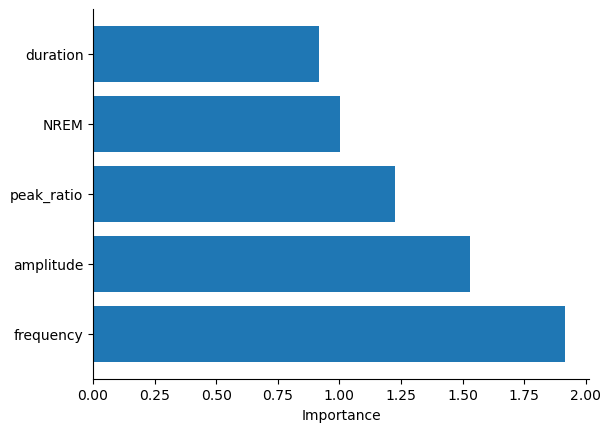

In [37]:
# Logistic regression

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
    
# Train with the default parameters: penalty='l2', solver='lbfgs', class_weight=None -> all classes have weight one
# Is used as a baseline/reference model

# Make the pipeline
pipe_logreg_base = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
display(pipe_logreg_base)

# Fit the model
pipe_logreg_base.fit(X_train, y_train)

# Show the model
logreg_base = pipe_logreg_base['logisticregression']
f_display_regression_model(logreg_base, predictors)
f_display_feature_importance(logreg_base, predictors)


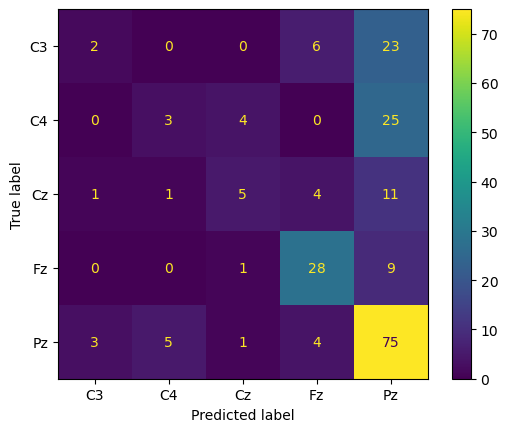

              precision    recall  f1-score   support

          C3     0.3333    0.0645    0.1081        31
          C4     0.3333    0.0938    0.1463        32
          Cz     0.4545    0.2273    0.3030        22
          Fz     0.6667    0.7368    0.7000        38
          Pz     0.5245    0.8523    0.6494        88

    accuracy                         0.5355       211
   macro avg     0.4625    0.3949    0.3814       211
weighted avg     0.4857    0.5355    0.4666       211



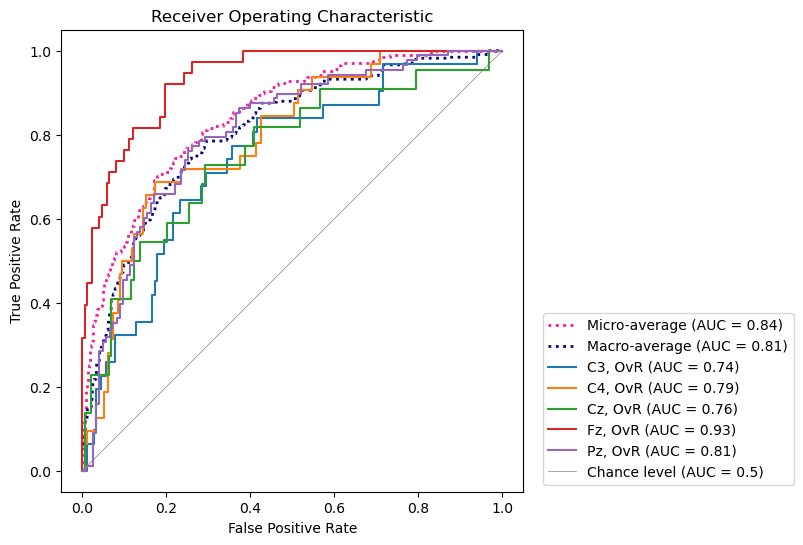

In [38]:
# Evaluate performace on the test set
y_test_hat = pipe_logreg_base.predict(X_test)
y_test_score = pipe_logreg_base.predict_proba(X_test)
target_names = pipe_logreg_base.classes_

# Display confusion matrix
f_display_confusion_matrix(y_test, y_test_hat, target_names)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat, digits=4))

# Display ROC & AUC
f_display_roc_auc(y_train, y_test, y_test_score)


In [39]:
df[target].value_counts()

channel
Pz         444
Fz         183
C4         149
C3         144
Cz         134
dtype: int64

We are dealing with imbalanced data. In such cases, using standard machine learning methods like logistic regression may result in poor performance, with the classifier tending to favor the majority class. Therefore, we need to use a weighted logistic regression and give more weight to the minority class. We can do so by passing to `LogisticRegression` `class_weight=balanced`. We can also test different solvers and determine which one is the best.

To evaluate the performance of the model, F1-score is used.


In [40]:
# Tuning parameters with `GridSearchCV`

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Make a pipeline
pipe_logreg = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', multi_class='multinomial', random_state=42))
display(pipe_logreg)

# Set parameters to tune
# As of 08-Mar-2023, `multinomial` option is supported only by the ‘lbfgs’, ‘sag’, ‘saga’ and ‘newton-cg’ solvers
solver_list = ['lbfgs', 'newton-cg','sag', 'saga']
param_grid ={
    'logisticregression__solver': solver_list,
}

# Do the search
# If the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used
grid_search = GridSearchCV(
    estimator=pipe_logreg,
    scoring='f1_micro',    
    param_grid=param_grid,
    n_jobs=-1, # The number of jobs to run in parallel; -1: use all processors
    cv=5,
)
grid_search.fit(X_train, y_train)

# Results
scoring = grid_search.get_params()['scoring']
if scoring is None:
    scoring = 'accuracy'
scores = grid_search.cv_results_['mean_test_score']

print(f'\n {scoring} scores:\n')
for score, solver in zip(scores, solver_list):
    print(f" {solver:<20} {score:.4f}" )

print(f'\nThe best {scoring} score: {grid_search.best_score_:.4f}')
print('\nThe best parameters:\n', (grid_search.best_params_))


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced',
                                    multi_class='multinomial',
                                    random_state=42))])


 f1_micro scores:

 lbfgs                0.4591
 newton-cg            0.4591
 sag                  0.4591
 saga                 0.4603

The best f1_micro score: 0.4603

The best parameters:
 {'logisticregression__solver': 'saga'}


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(class_weight='balanced', cv=5,
                                      multi_class='multinomial',
                                      random_state=42, solver='saga'))])

y_hat = 0.0782 + (-0.0145)*duration + (0.0920)*peak_ratio + (0.2540)*frequency + (0.0802)*amplitude + (-0.0125)*NREM

Logistic regression: the Euler number to the power of each weight is considered.


feature  importance
0   frequency    1.289131
1  peak_ratio    1.096312
2   amplitude    1.083455
3        NREM    0.987575
4    duration    0.985605

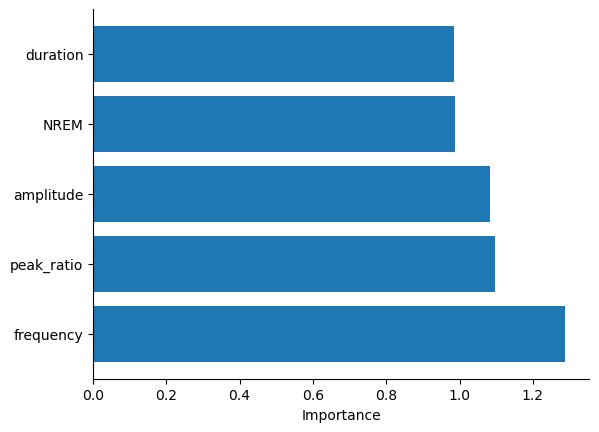

In [41]:
# The best logistic regression model using cross validation

from sklearn.linear_model import LogisticRegressionCV
    
# Make the pipeline
logreg_cv = LogisticRegressionCV(cv=5, penalty='l2', solver='saga', class_weight='balanced', multi_class='multinomial', random_state=42)
pipe_logreg_best = make_pipeline(StandardScaler(), logreg_cv)
display(pipe_logreg_best)

# Fit the model
pipe_logreg_best.fit(X_train, y_train)

# Show the model
logreg_best = pipe_logreg_best['logisticregressioncv']
f_display_regression_model(logreg_best, predictors)
f_display_feature_importance(logreg_best, predictors)


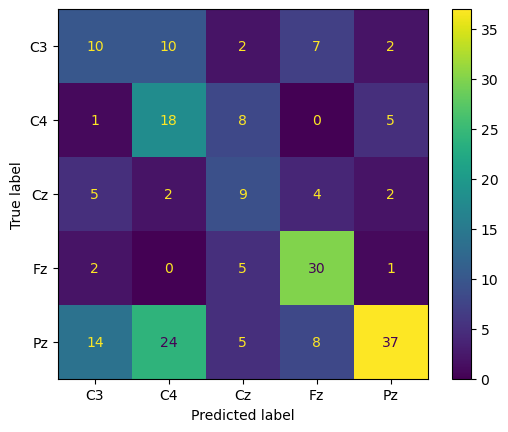

              precision    recall  f1-score   support

          C3     0.3125    0.3226    0.3175        31
          C4     0.3333    0.5625    0.4186        32
          Cz     0.3103    0.4091    0.3529        22
          Fz     0.6122    0.7895    0.6897        38
          Pz     0.7872    0.4205    0.5481        88

    accuracy                         0.4929       211
   macro avg     0.4711    0.5008    0.4654       211
weighted avg     0.5674    0.4929    0.4997       211



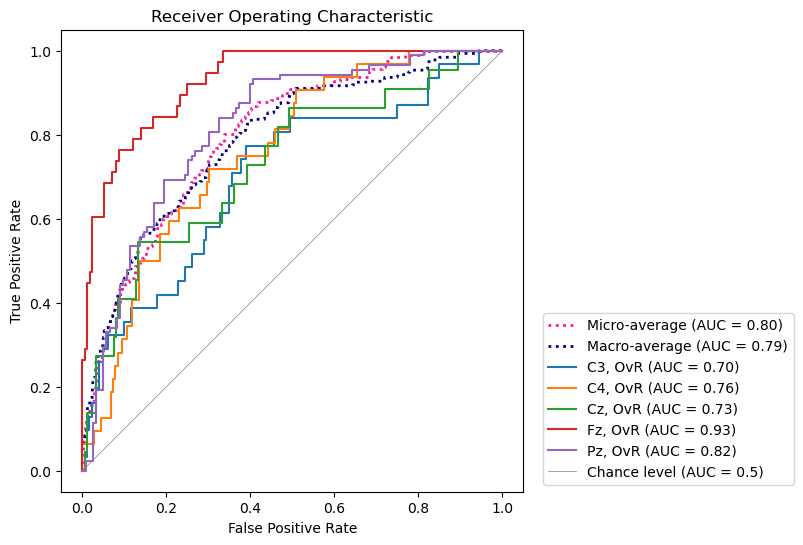

In [42]:
# Evaluate performace on the test set
y_test_hat = pipe_logreg_best.predict(X_test)
y_test_score = pipe_logreg_best.predict_proba(X_test)
target_names = pipe_logreg_best.classes_

# Display confusion matrix
f_display_confusion_matrix(y_test, y_test_hat, target_names)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat, digits=4))

# Display ROC & AUC
f_display_roc_auc(y_train, y_test, y_test_score)



 THE BASE MODEL
              precision    recall  f1-score   support

          C3     0.3333    0.0645    0.1081        31
          C4     0.3333    0.0938    0.1463        32
          Cz     0.4545    0.2273    0.3030        22
          Fz     0.6667    0.7368    0.7000        38
          Pz     0.5245    0.8523    0.6494        88

    accuracy                         0.5355       211
   macro avg     0.4625    0.3949    0.3814       211
weighted avg     0.4857    0.5355    0.4666       211


 THE BEST MODEL
              precision    recall  f1-score   support

          C3     0.3125    0.3226    0.3175        31
          C4     0.3333    0.5625    0.4186        32
          Cz     0.3103    0.4091    0.3529        22
          Fz     0.6122    0.7895    0.6897        38
          Pz     0.7872    0.4205    0.5481        88

    accuracy                         0.4929       211
   macro avg     0.4711    0.5008    0.4654       211
weighted avg     0.5674    0.4929    0.4997

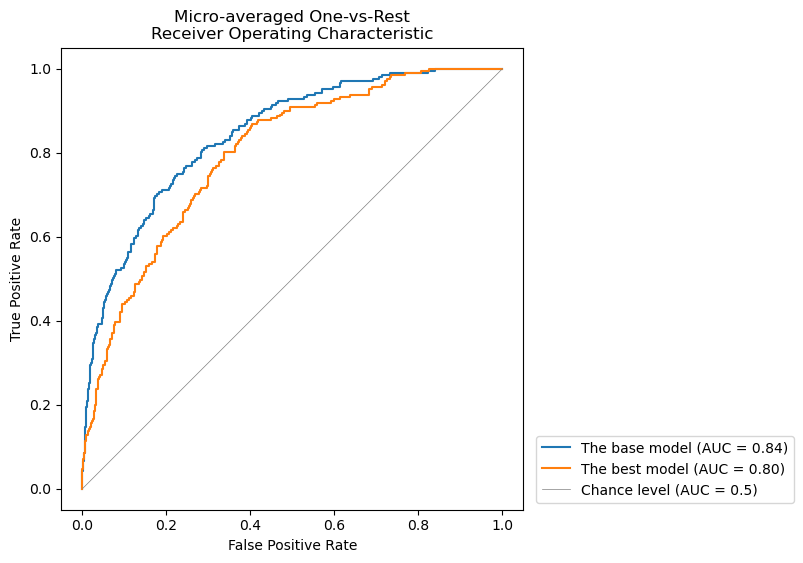

In [43]:
# Compare models

# --- Classification report

from sklearn.metrics import classification_report

# Calculate predicted values for the base and the best model
y_hats = {
    'The base model': pipe_logreg_base.predict(X_test),
    'The best model': pipe_logreg_best.predict(X_test),
}

for model, y_hat in y_hats.items():
    print('\n', model.upper())
    print(classification_report(y_test, y_hat, digits=4))


# --- ROC & AUC

from sklearn import metrics
import matplotlib.pyplot as plt
    
# Binarize the target `y_test` by one-hot-encoding in a one-vs-rest fashion
# The procedure maps the target of shape (`n_samples`) to a target of shape (`n_samples`, `n_classes`)
target_names, y_test_onehot = f_get_binarized(y_train, y_test)

# Calculate scores for the base and the best model
y_test_scores = {
    'The base model': pipe_logreg_base.predict_proba(X_test),
    'The best model': pipe_logreg_best.predict_proba(X_test),
}

# Plot
f_display_roc_auc_micro(y_test_onehot, y_test_scores)


In [44]:
# Model with the PCA-transformed variables

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
    
# Make the pipeline
logreg = LogisticRegression(penalty='l2', solver='saga', class_weight='balanced', random_state=42)
pipe_pca_logreg = make_pipeline(StandardScaler(), PCA(), logreg)
display(pipe_pca_logreg)

# Set parameters to tune
n_components_list = list(np.arange(2, len(predictors) + 1))
param_grid ={
    'pca__n_components': n_components_list,
}

# Do the search
# If the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used
grid_search = GridSearchCV(
    estimator=pipe_pca_logreg,
    scoring='f1_micro',    
    param_grid=param_grid,
    n_jobs=-1, # The number of jobs to run in parallel; -1: all processors
    cv=5,
)
grid_search.fit(X_train, y_train)

# Results
scoring = grid_search.get_params()['scoring']
if scoring is None:
    scoring = 'accuracy'
scores = grid_search.cv_results_['mean_test_score']

print(f'\n{scoring} scores:\n')
for score, n_components in zip(scores, n_components_list):
    print(f'PCA with {n_components} components {score:10.4f}')

print(f'\nThe best {scoring} score: {grid_search.best_score_:.4f}')
print('\nThe best parameters:\n', (grid_search.best_params_))


Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='saga'))])


f1_micro scores:

PCA with 2 components     0.4010
PCA with 3 components     0.4271
PCA with 4 components     0.4496
PCA with 5 components     0.4591

The best f1_micro score: 0.4591

The best parameters:
 {'pca__n_components': 5}


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=5))])

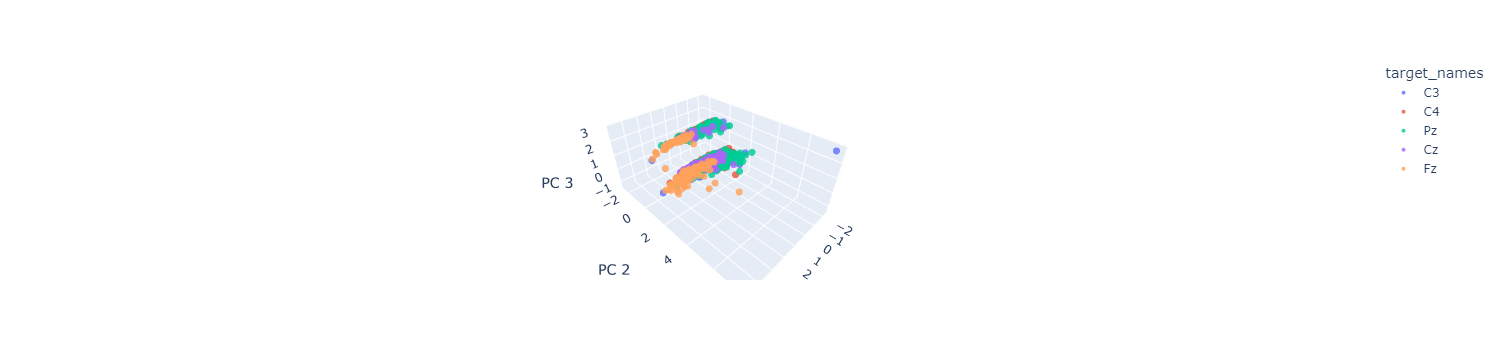

In [45]:
# Visualize the first three PCs

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt

# Make the pipeline
pipe_pca = make_pipeline(StandardScaler(), PCA(n_components=5))
display(pipe_pca)

# Transform the data
X_train_pca = pipe_pca.fit_transform(X_train)

# Plot
# target_names = target_names = np.unique(y_train)
# colors = []
# for y in y_train:
#     for i in range(len(target_names)):
#         if y == target_names[i]:
#             colors.append(i)
#             break
import plotly.express as px

df2plot = pd.DataFrame(list(zip(y_train, X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2])),
               columns =['target_names', 'PC 1', 'PC 2', 'PC 3'])

fig = px.scatter_3d(df2plot, x='PC 1', y='PC 2', z='PC 3',
                    color='target_names')

fig.update_traces(marker=dict(size=4, opacity=0.8))
fig.show()




y_hat = 0.0782 + (-0.1463)*pc1 + (0.0791)*pc2 + (0.0376)*pc3 + (-0.0227)*pc4 + (0.2240)*pc5

Logistic regression: the Euler number to the power of each weight is considered.


feature  importance
0     pc5    1.251041
1     pc2    1.082302
2     pc3    1.038366
3     pc4    0.977574
4     pc1    0.863927

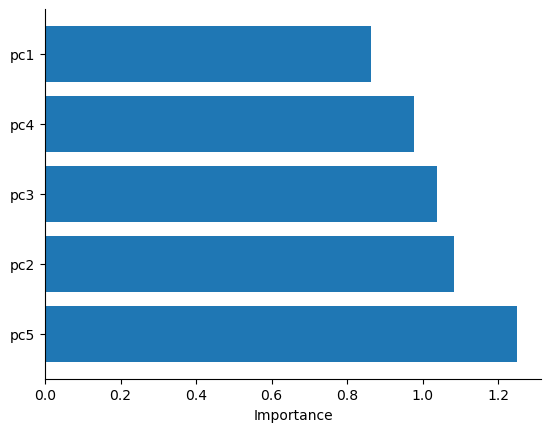

In [46]:
# The model with the best parameters using principle components and cross validation

from sklearn.linear_model import LogisticRegressionCV

# Fit the model
pca_logreg_cv = LogisticRegressionCV(cv=5, penalty='l2', solver='saga', class_weight='balanced', multi_class='multinomial', random_state=42)
pca_logreg_cv.fit(X_train_pca, y_train)

# Show the model
f_display_regression_model(pca_logreg_cv, ['pc1', 'pc2', 'pc3', 'pc4', 'pc5'])
f_display_feature_importance(pca_logreg_cv, ['pc1', 'pc2', 'pc3', 'pc4', 'pc5'])


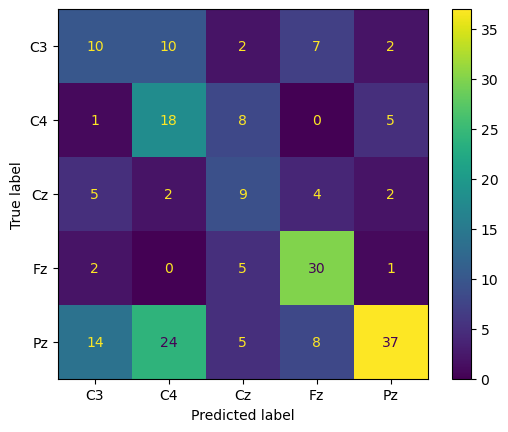

              precision    recall  f1-score   support

          C3     0.3125    0.3226    0.3175        31
          C4     0.3333    0.5625    0.4186        32
          Cz     0.3103    0.4091    0.3529        22
          Fz     0.6122    0.7895    0.6897        38
          Pz     0.7872    0.4205    0.5481        88

    accuracy                         0.4929       211
   macro avg     0.4711    0.5008    0.4654       211
weighted avg     0.5674    0.4929    0.4997       211



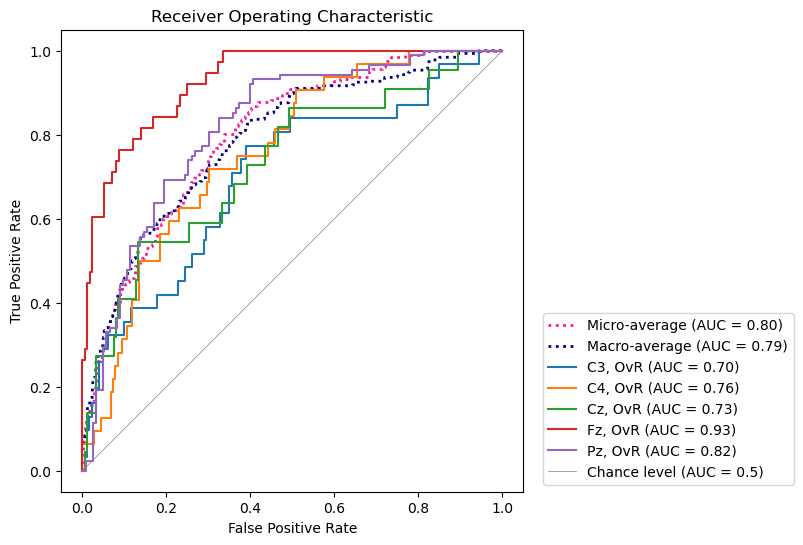

In [47]:
# Evaluate performace on the test set

# Get principle components for the test set
X_test_pca = pipe_pca.transform(X_test)

y_test_hat = pca_logreg_cv.predict(X_test_pca)
y_test_score = pca_logreg_cv.predict_proba(X_test_pca)
target_names = pca_logreg_cv.classes_

# Display confusion matrix
f_display_confusion_matrix(y_test, y_test_hat, target_names)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat, digits=4))

# Display ROC & AUC
f_display_roc_auc(y_train, y_test, y_test_score)



 THE BASE MODEL
              precision    recall  f1-score   support

          C3     0.3333    0.0645    0.1081        31
          C4     0.3333    0.0938    0.1463        32
          Cz     0.4545    0.2273    0.3030        22
          Fz     0.6667    0.7368    0.7000        38
          Pz     0.5245    0.8523    0.6494        88

    accuracy                         0.5355       211
   macro avg     0.4625    0.3949    0.3814       211
weighted avg     0.4857    0.5355    0.4666       211


 THE BEST MODEL
              precision    recall  f1-score   support

          C3     0.3125    0.3226    0.3175        31
          C4     0.3333    0.5625    0.4186        32
          Cz     0.3103    0.4091    0.3529        22
          Fz     0.6122    0.7895    0.6897        38
          Pz     0.7872    0.4205    0.5481        88

    accuracy                         0.4929       211
   macro avg     0.4711    0.5008    0.4654       211
weighted avg     0.5674    0.4929    0.4997

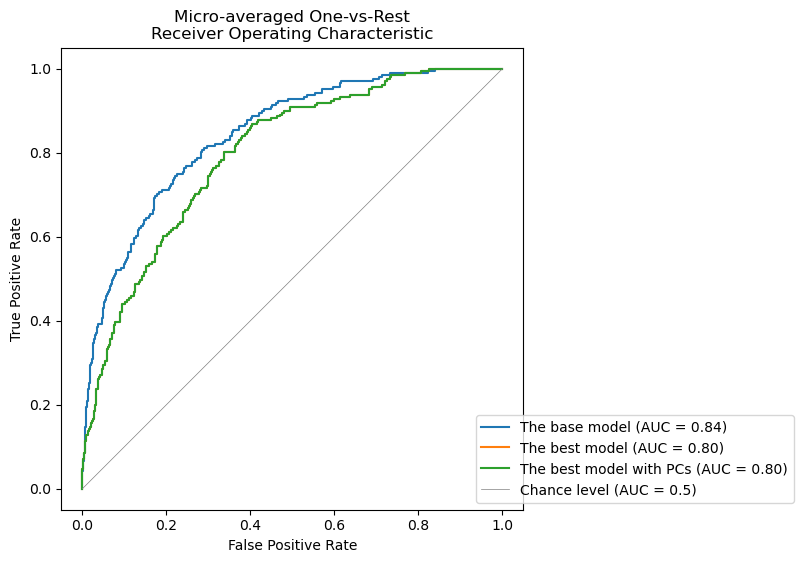

In [48]:
# Compare models

# --- Classification report

from sklearn.metrics import classification_report

# Calculate predicted values for the base and the best model
y_hats = {
    'The base model': pipe_logreg_base.predict(X_test),
    'The best model': pipe_logreg_best.predict(X_test),
    'The best model with PCs': pca_logreg_cv.predict(X_test_pca),    
}

for model, y_hat in y_hats.items():
    print('\n', model.upper())
    print(classification_report(y_test, y_hat, digits=4))


# --- ROC & AUC

from sklearn import metrics
import matplotlib.pyplot as plt
    
# Binarize the target `y_test` by one-hot-encoding in a one-vs-rest fashion
# The procedure maps the target of shape (`n_samples`) to a target of shape (`n_samples`, `n_classes`)
target_names, y_test_onehot = f_get_binarized(y_train, y_test)

# Calculate scores for the base and the best model
y_test_scores = {
    'The base model': pipe_logreg_base.predict_proba(X_test),
    'The best model': pipe_logreg_best.predict_proba(X_test),
    'The best model with PCs': pca_logreg_cv.predict_proba(X_test_pca),
}

# Plot
f_display_roc_auc_micro(y_test_onehot, y_test_scores)


#### Random Forest

**Approach**

1. Build a base tree using `DecisionTreeClassifier` with the default parameters
2. Determine the best parameters for `RandomForestClassifier` using the `GreadSearchCV` object
3. Create a classifier using `RandomForestClassifier` with the best parameters

Performance of the models is evaluated using previously unseen observations (i.e., the test set)

In [49]:
# Decision tree

# --- Train with the default parameters
from sklearn.tree import DecisionTreeClassifier

# The parameters: criterion='gini', min_samples_split=2 with nodes expanded until all leaves contain less than two samples and
# unlimited number of leaf nodes.
# Is used as a baseline/reference model
dtc = DecisionTreeClassifier(random_state=42)
display(dtc)
dtc.fit(X_train, y_train)

# --- Show the model
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

# Create DOT data and show
dot_data = export_graphviz(dtc, out_file = None, feature_names =predictors)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())


DecisionTreeClassifier(random_state=42)

feature  importance
0   frequency    0.290285
1   amplitude    0.287116
2    duration    0.225859
3  peak_ratio    0.179041
4        NREM    0.017699

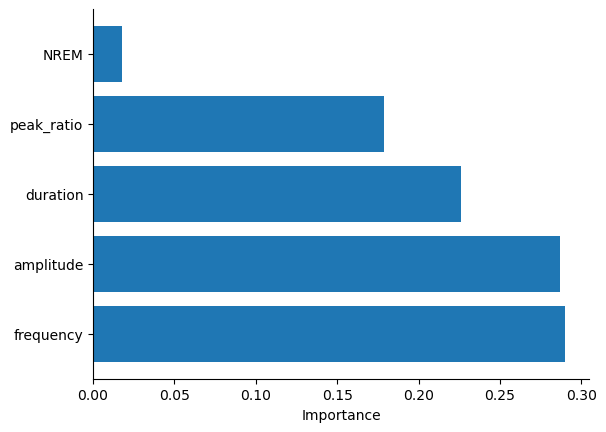

In [50]:
# Feature importnace
f_display_feature_importance(dtc, predictors)


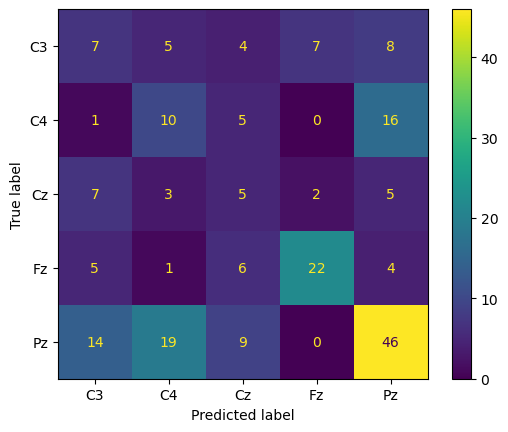

              precision    recall  f1-score   support

          C3     0.2059    0.2258    0.2154        31
          C4     0.2632    0.3125    0.2857        32
          Cz     0.1724    0.2273    0.1961        22
          Fz     0.7097    0.5789    0.6377        38
          Pz     0.5823    0.5227    0.5509        88

    accuracy                         0.4265       211
   macro avg     0.3867    0.3735    0.3772       211
weighted avg     0.4588    0.4265    0.4400       211



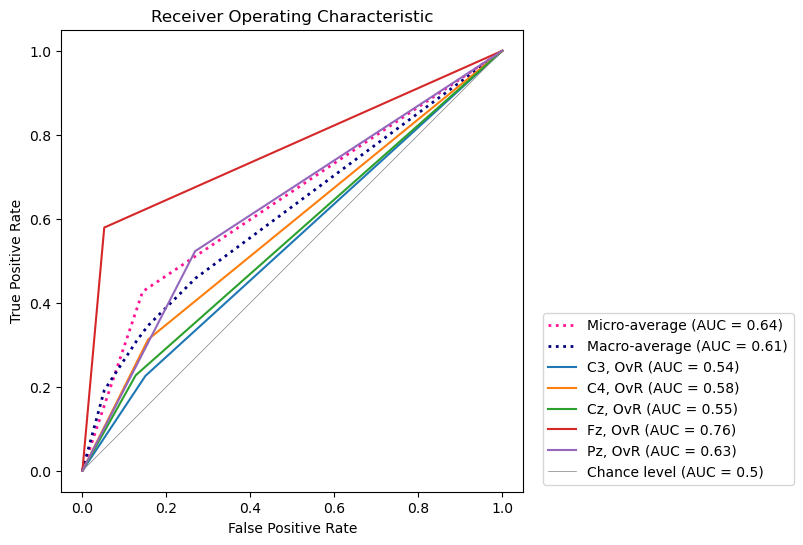

In [51]:
# Evaluate performace on the test set

y_test_hat = dtc.predict(X_test)
y_test_score = dtc.predict_proba(X_test)
target_names = dtc.classes_

# Display confusion matrix
f_display_confusion_matrix(y_test, y_test_hat, target_names)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat, digits=4))

# Display ROC & AUC
f_display_roc_auc(y_train, y_test, y_test_score)


In [ ]:
# Tuning parameters for `RandomForestClassifier` with `GridSearchCV`

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Set parameters to tune
solver_list = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
param_grid ={
    'n_estimators': [25, 50, 100, 200],
    'max_features': ['sqrt', 'log2'], # Number of features to consider at every split
    'max_depth': [10, 20, None],
    'criterion': ['gini', 'entropy'],
    'max_leaf_nodes': [3, 6, 9, None],
}

# Do the search
# If the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    scoring='f1_micro',    
    param_grid=param_grid,
    n_jobs=-1, # The number of jobs to run in parallel; -1: use all processors
    cv=5,
)
grid_search.fit(X_train, y_train)

# Results
scoring = grid_search.get_params()['scoring']
if scoring is None:
    scoring = 'accuracy'
scores = grid_search.cv_results_['mean_test_score']

print(f'\n {scoring} scores:\n')
print(scores)

print(f'\nThe best {scoring} score: {grid_search.best_score_:.4f}')
print('\nThe best parameters:\n', (grid_search.best_params_))


In [ ]:
# Create the best tree using `RandomForestClassifier` with the best parameters

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(
    n_estimators=200,
    criterion='gini',
    max_depth=10,
    max_features='sqrt',
    max_leaf_nodes=None,
    random_state=42,
)

rfc.fit(X_train, y_train)


In [ ]:
# Feature importnace
f_display_feature_importance(rfc, predictors)


In [ ]:
# Evaluate performace on the test set

y_test_hat = rfc.predict(X_test)
y_test_score = rfc.predict_proba(X_test)
target_names = rfc.classes_

# Display confusion matrix
f_display_confusion_matrix(y_test, y_test_hat, target_names)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat, digits=4))

# Display ROC & AUC
f_display_roc_auc(y_train, y_test, y_test_score)


In [ ]:
# Compare models

# --- Classification report

from sklearn.metrics import classification_report

# Calculate predicted values for the base and the best model
y_hats = {
    'Decision tree': dtc.predict(X_test),
    'The best random forest': rfc.predict(X_test),
}

for model, y_hat in y_hats.items():
    print('\n', model.upper())
    print(classification_report(y_test, y_hat, digits=4))


# --- ROC & AUC

from sklearn import metrics
import matplotlib.pyplot as plt
    
# Binarize the target `y_test` by one-hot-encoding in a one-vs-rest fashion
# The procedure maps the target of shape (`n_samples`) to a target of shape (`n_samples`, `n_classes`)
target_names, y_test_onehot = f_get_binarized(y_train, y_test)

# Calculate scores for the base and the best model
y_test_scores = {
    'Decision tree': dtc.predict_proba(X_test),
    'The best random forest': rfc.predict_proba(X_test),
}

# Plot
f_display_roc_auc_micro(y_test_onehot, y_test_scores)
